from collections import defaultdict
from scipy.stats import pearsonr, spearmanr, kendalltau

import pandas as pd 
import numpy as np
import joblib
import os

import matplotlib.pyplot as plt
import seaborn as sns

Process the baseline results at both **system-level** and **instance-level**. We will measure the performance at the **dev** and **test sets**. Note that every model/experiment decision, should only rely on the results available for **dev** set. 

In [2]:
def flatten_summ(dataset: dict) -> list:
    """
    {
        "doc_id": {
            "src": "This is the source text.",
            "ref_summ": "This is the reference summary",
            "sys_summs": {
                "sys_name1": {
                    "sys_summ": "This is the system summary.",
                    "scores": {
                        "human_metric1": 0.3,
                        "human_metric2": 0.5
    }}}}}
    """
    flattened = []
    
    for doc_id, doc_data in dataset.items():
        for sys_name, sys_data in doc_data["sys_summs"].items():
            data = {
                "bartscore_doc_id": doc_id,
                "src": doc_data["src"],
                "ref_summ": doc_data["ref_summ"],
                "sys_name": sys_name,
                "sys_summ": sys_data["sys_summ"],
            }
            
            data.update({f"{col}": score for col, score in sys_data["scores"].items()})
            flattened.append(data)
    return flattened


def read_scores_data(dataset_name, parent_dir, **_):
    data: dict = joblib.load(f"{parent_dir}/{dataset_name}_scores.pkl")
    data = flatten_summ(data)
    data = pd.DataFrame(data).reset_index()
    
    for col in ("bert_score_p", "bert_score_r", "bert_score_f"):
        if col in data.columns:
            data[col] = data[col].apply(float)
    
    return data

However, we need to filter the results based on the dev and test splits.

In [3]:
def get_eval_ids(dataset_name, dataset_classes, parent_dir, splits=("dev", "test"), **_):
    split_ids = {}

    for split in splits:
        filepath = f"{parent_dir}/{dataset_name}/{dataset_classes}_{split}.csv"
        data_split = pd.read_csv(filepath)

        ids = sorted(data_split["bartscore_doc_id"].unique())
        split_ids[split] = ids
        
    return split_ids


def filter_by_ids(data: pd.DataFrame, ids_list: list):
    return data[data["bartscore_doc_id"].isin(ids_list)]

System- and instance-level correlations are useful to compare the baselines.

### Instance-level correlation

Compute the correlation between the metric values for all instances in the dataset. That is for each instance i, compute the metric value assigned to all generated summaries of system 1..j. Repeat with a second metric. Measure their correlation. Average the correlation over the different instances in the dataset.

In [4]:
def _get_instance_level_correlation(data: pd.DataFrame, metrics: list, target_col: str, corr_method: callable) -> dict:
    name = corr_method.__name__
    print("Computing", name, "with", target_col, "col")
    
    # Pseudo algorithm
    # 1. Iterate over each doc_id
    # 2. Compute the correlation between different metric values for each doc_id and the human values
    # 3. Avg correlation coefficients in the end
    instance_level_corrs = defaultdict(list)

    for iid in data["bartscore_doc_id"].unique():
        for m in metrics:
            instance = data[data["bartscore_doc_id"] == iid]

            corr, p_val = corr_method(instance[m], instance[target_col])
            instance_level_corrs[m].append(corr)
           
    # Compute the avg (#TODO - handle p_val)
    instance_level_corrs_avg = {metric: np.mean(corr_data) for metric, corr_data in instance_level_corrs.items()}
    return instance_level_corrs_avg

def compute_instance_level_correlations(data, metrics, target_col, dataset_name, output_dir, to_persist=True, **_):
    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_instance_level_correlation(data, metrics, target_col, corr_method)

        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_instance_corrs.csv", index=0)
    
    return correlations

### System-level correlation

Compute the correlation between the avg values assigned by the two metrics to each system.


In [5]:
def _get_system_level_correlation(data, metrics, target_col, systems, corr_method: callable) -> dict:
    # pseudo code
    # for each system
    # compute the mean score attributed by a metric m to the outputs of each system.
    # compute the mean score attributed by a target_col to the outputs of each system.
    # compute correlation
    system_level_correlation = defaultdict(list)
    for sys in systems:
        data_sys = data[data["sys_name"] == sys]
        # ^Note: since we're computing the mean, we dont need to ensure the ordering

        for m in metrics + [target_col]:
            mean_sys = data_sys[m].mean()
            system_level_correlation[m].append(mean_sys)

    # Compute the correlation now
    correlations = {}
    for m in metrics:
        corr, p_val = corr_method(system_level_correlation[m], system_level_correlation[target_col])

        correlations[m] = round(corr, 4)

    return correlations


def compute_system_level_correlations(data, metrics, target_col, dataset_name, systems, output_dir, to_persist=True, **_):

    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_system_level_correlation(data, metrics, target_col, systems, corr_method)
        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_system_corrs.csv", index=0)
    
    return correlations

### Get T0 baselines

In [6]:
from glob import glob


def get_t0_baselines(dataset_name: str, dataset_classes: str, parent_dir: str, output_dir="./t-few-master/exp_out", **_kwargs):
    def extract_name(path: str) -> str:
        # Given a path in the format
        # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/<something>
        # 1. Extract the parent dir `t03b_realsumm_baseline_ft_train`
        exp_name = path.split("/")[-2]
        
        # 2. Keep all parts including baseline and afterwards
        index_baseline = exp_name.index("baseline")
        return exp_name[index_baseline:]
        
    
    output_dir = f"{output_dir}/{dataset_name.lower()}/{dataset_classes}"
    t0_baselines = "t03b_*_baseline*"
    
    dev_files = glob(os.path.join(output_dir, t0_baselines, "dev_pred.txt"))
    print(f"Find {len(dev_files)} experiments fit into {t0_baselines}")
    print("\t -->", "\n\t --> ".join(dev_files))
    print()
        
    test_files = glob(os.path.join(output_dir, t0_baselines, "test_pred.txt"))
    print(f"Find {len(test_files)} experiments fit into {t0_baselines}")
    print("\t -->", "\n\t --> ".join(test_files))
    print()
    
    # The result of the files will be:
    # ['./t-few-master/exp_out/realsumm/t03b_realsumm_baseline/dev_pred.txt',
    #  './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/dev_pred.txt',
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train_20k_steps/dev_pred.txt', 
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all/dev_pred.txt',
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_all_20k_steps/dev_pred.txt'
    # ]
    # As such, we will extract the name of the baseline using the `extract_name` method, 
    # e.g., `baseline`, `baseline_ft_train`, `baseline_ft_train_20k_steps`, ...
    dev_data = {extract_name(path): pd.read_csv(path) for path in dev_files}
    test_data = {extract_name(path): pd.read_csv(path) for path in test_files}

    # Before returning the dataframe, we will recover the bartscore_doc_id
    # to facilitate re-use of previous correlation methods.
    dev_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_dev.csv")[["index", "sys_name", "bartscore_doc_id"]]
    test_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_test.csv")[["index", "sys_name", "bartscore_doc_id"]]
    
    dev_corpora = {}
    for baseline, data in dev_data.items():
        data = data.merge(dev_original_df, left_on="idx", right_on="index")
        dev_corpora[baseline] = data
    
    test_corpora = {}
    for baseline, data in test_data.items():
        data = data.merge(test_original_df, left_on="idx", right_on="index")
        test_corpora[baseline] = data
        
    print("Baselines (for dev):\n ->", list(dev_corpora.keys()))
    print("Baselines (for test):\n ->", list(test_corpora.keys()))
    return dev_corpora, test_corpora


def compute_split_correlations(
    split, 
    split_baselines, 
    dataset_split, 
    dataset_name, 
    dataset_classes, 
    parent_dir, 
    output_dir, 
    target_col, 
    systems, 
    tag="t0_baselines",
    **_
):
    instance_baseline_corrs = []
    system_baseline_corrs = []
        
    for baseline, data in split_baselines.items():
        print("-" * 80)
        print("Computing correlations for", baseline)
        print("-" * 80)

        d = dataset_split[["bartscore_doc_id", "sys_name", target_col]]
        ds = data.merge(d, on=["sys_name", "bartscore_doc_id"], how="inner")

        instance_corr = compute_instance_level_correlations(
            ds,
            metrics=["log.scores_class_1"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            to_persist=False,
        )

        system_corr = compute_system_level_correlations(
            ds, 
            metrics=["log.scores_class_1"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            systems=systems,
            to_persist=False
        )

        instance_corr["index"] = baseline
        system_corr["index"] = baseline

        instance_baseline_corrs.append(instance_corr)
        system_baseline_corrs.append(system_corr)
        
    instance_baseline_corrs = pd.concat(instance_baseline_corrs)
    system_baseline_corrs = pd.concat(system_baseline_corrs)

    dataset_name = f"{dataset_name}_{dataset_classes}_{tag}_{split}"
    instance_baseline_corrs.reset_index().to_csv(f"{output_dir}/{dataset_name}_inst_corrs.csv", index=0)
    system_baseline_corrs.reset_index().to_csv(f"{output_dir}/{dataset_name}_system_corrs.csv", index=0)
    
    return instance_baseline_corrs, system_baseline_corrs

### Compute metrics

In [7]:
def compute_metrics(df: pd.DataFrame):
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
    from scipy.stats import pearsonr, spearmanr, kendalltau
    
    metrics = {}
    
    kwargs = {"y_true": df['label'], "y_pred": df["prediction"]}
    metrics["precision"] = precision_score(**kwargs)
    metrics["recall"] = recall_score(**kwargs)
    metrics["f1_score"] = f1_score(**kwargs)
    
    tn, fp, fn, tp = confusion_matrix(**kwargs).ravel()
    
    metrics["tn"] = tn
    metrics["fp"] = fp
    metrics["fn"] = fn
    metrics["tp"] = tp
    
    metrics["lp"] = metrics["tp"] + metrics["fn"]
    metrics["ln"] = metrics["fp"] + metrics["tn"]
    metrics["pp"] = metrics["tp"] + metrics["fp"]
    metrics["pn"] = metrics["tn"] + metrics["fn"]
    
    metrics["n"] = len(df)
    metrics["fpr"] = fp / (fp + tn)
    metrics["fnr"] = 1 - metrics["recall"]
    
    metrics["accuracy"] = accuracy_score(**kwargs)
    
    
    return metrics

## REAL Summarization

In [8]:
realsumm_metadata = {
    "dataset_name": "REALSumm",
    "dataset_classes": "2class",
    "parent_dir": "./experiments/summ_data",
    "target_col": "litepyramid_recall",
    "splits": ("dev", "test"),
    "output_dir": "./results/summ",
    "metrics": [
    # BERTScore
    'bert_score_p','bert_score_r','bert_score_f',
    'mover_score',
    # PRISM
    'prism_ref_hypo','prism_hypo_ref','prism_avg','prism_src_hypo',
    # ROUGE
    'rouge1_r','rouge1_p','rouge1_f',
    'rouge2_r','rouge2_p','rouge2_f',
    'rougel_r','rougel_p','rougel_f',
    # BARTScore
    'bart_score_cnn_ref_hypo_en', 'bart_score_cnn_ref_hypo_de',
    'bart_score_cnn_hypo_ref_en','bart_score_cnn_hypo_ref_de',
    'bart_score_cnn_avg_f_en','bart_score_cnn_avg_f_de',
    'bart_score_cnn_harm_f_en','bart_score_cnn_harm_f_de',
    'bart_score_src_hypo','bart_score_hypo_ref','bart_score_ref_hypo','bart_score_avg_f','bart_score_harm_f',
    'bart_score_cnn_src_hypo','bart_score_cnn_hypo_ref','bart_score_cnn_ref_hypo','bart_score_cnn_avg_f','bart_score_cnn_harm_f',
    'bart_score_para_src_hypo','bart_score_para_hypo_ref','bart_score_para_ref_hypo','bart_score_para_avg_f','bart_score_para_harm_f',
],
}

In [9]:
realsumm = read_scores_data(**realsumm_metadata)
realsumm_metadata["systems"] = sorted(realsumm["sys_name"].unique())
print(realsumm_metadata)
realsumm_eval_ids = get_eval_ids(**realsumm_metadata)

# Subset development and test sets
realsumm_dev = filter_by_ids(realsumm, realsumm_eval_ids["dev"])
realsumm_test = filter_by_ids(realsumm, realsumm_eval_ids["test"])

dev_dataset_name = f"{realsumm_metadata['dataset_name']}_{realsumm_metadata['dataset_classes']}_dev"
test_dataset_name = f"{realsumm_metadata['dataset_name']}_{realsumm_metadata['dataset_classes']}_test"

orig_dataset_name = realsumm_metadata.pop("dataset_name")

realsumm_metadata["dataset_name"] = dev_dataset_name
compute_instance_level_correlations(realsumm_dev, **realsumm_metadata)
compute_system_level_correlations(realsumm_dev, **realsumm_metadata)

realsumm_metadata["dataset_name"] = test_dataset_name
compute_instance_level_correlations(realsumm_test, **realsumm_metadata)
compute_system_level_correlations(realsumm_test, **realsumm_metadata)

realsumm_metadata["dataset_name"] = orig_dataset_name

{'dataset_name': 'REALSumm', 'dataset_classes': '2class', 'parent_dir': './experiments/summ_data', 'target_col': 'litepyramid_recall', 'splits': ('dev', 'test'), 'output_dir': './results/summ', 'metrics': ['bert_score_p', 'bert_score_r', 'bert_score_f', 'mover_score', 'prism_ref_hypo', 'prism_hypo_ref', 'prism_avg', 'prism_src_hypo', 'rouge1_r', 'rouge1_p', 'rouge1_f', 'rouge2_r', 'rouge2_p', 'rouge2_f', 'rougel_r', 'rougel_p', 'rougel_f', 'bart_score_cnn_ref_hypo_en', 'bart_score_cnn_ref_hypo_de', 'bart_score_cnn_hypo_ref_en', 'bart_score_cnn_hypo_ref_de', 'bart_score_cnn_avg_f_en', 'bart_score_cnn_avg_f_de', 'bart_score_cnn_harm_f_en', 'bart_score_cnn_harm_f_de', 'bart_score_src_hypo', 'bart_score_hypo_ref', 'bart_score_ref_hypo', 'bart_score_avg_f', 'bart_score_harm_f', 'bart_score_cnn_src_hypo', 'bart_score_cnn_hypo_ref', 'bart_score_cnn_ref_hypo', 'bart_score_cnn_avg_f', 'bart_score_cnn_harm_f', 'bart_score_para_src_hypo', 'bart_score_para_hypo_ref', 'bart_score_para_ref_hypo', 'b

### Get T0 baseline correlations

In [10]:
dev_baselines, test_baselines = get_t0_baselines(
    "REALSumm",
    "2class", 
    "./experiments/summ_data/",
    output_dir="./t-few-master/exp_out_2022_sep_10")
print("=" * 80)
print(" " *30,"DEV SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="dev",
    split_baselines=dev_baselines,
    dataset_split=realsumm_dev, 
    **realsumm_metadata
);
print("=" * 80)
print(" " *30,"TEST SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="test",
    split_baselines=test_baselines,
    dataset_split=realsumm_test, 
    **realsumm_metadata
); 

Find 5 experiments fit into t03b_*_baseline*
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline_ft_all/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline_ft_all_10k_steps/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline_ft_train/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline_ft_train_10k_steps/dev_pred.txt

Find 5 experiments fit into t03b_*_baseline*
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline/test_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline_ft_all/test_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline_ft_all_10k_steps/test_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_baseline_ft_tra

In [11]:
dev_metrics = {}

for baseline, baseline_df in dev_baselines.items():
    dev_metrics[baseline] = compute_metrics(baseline_df)
    
    
dev_metrics_baselines = pd.DataFrame(dev_metrics).T.reset_index()
dev_metrics_baselines

index  precision    recall  f1_score     tn     fp  \
0                     baseline   0.413793  0.043478  0.078689  427.0   17.0   
1              baseline_ft_all   0.723881  0.702899  0.713235  370.0   74.0   
2    baseline_ft_all_10k_steps   0.829193  0.967391  0.892977  389.0   55.0   
3            baseline_ft_train   0.649485  0.456522  0.536170  376.0   68.0   
4  baseline_ft_train_10k_steps   0.532394  0.684783  0.599049  278.0  166.0   

      fn     tp     lp     ln     pp     pn      n       fpr       fnr  \
0  264.0   12.0  276.0  444.0   29.0  691.0  720.0  0.038288  0.956522   
1   82.0  194.0  276.0  444.0  268.0  452.0  720.0  0.166667  0.297101   
2    9.0  267.0  276.0  444.0  322.0  398.0  720.0  0.123874  0.032609   
3  150.0  126.0  276.0  444.0  194.0  526.0  720.0  0.153153  0.543478   
4   87.0  189.0  276.0  444.0  355.0  365.0  720.0  0.373874  0.315217   

   accuracy  
0  0.609722  
1  0.783333  
2  0.911111  
3  0.697222  
4  0.648611

In [12]:
test_metrics = {}

for baseline, baseline_df in test_baselines.items():
    test_metrics[baseline] = compute_metrics(baseline_df)
    
pd.DataFrame(test_metrics).T.reset_index()

index  precision    recall  f1_score     tn     fp  \
0                     baseline   0.400000  0.112450  0.175549  429.0   42.0   
1              baseline_ft_all   0.715447  0.706827  0.711111  401.0   70.0   
2    baseline_ft_all_10k_steps   0.831034  0.967871  0.894249  422.0   49.0   
3            baseline_ft_train   0.566667  0.477912  0.518519  380.0   91.0   
4  baseline_ft_train_10k_steps   0.491667  0.710843  0.581281  288.0  183.0   

      fn     tp     lp     ln     pp     pn      n       fpr       fnr  \
0  221.0   28.0  249.0  471.0   70.0  650.0  720.0  0.089172  0.887550   
1   73.0  176.0  249.0  471.0  246.0  474.0  720.0  0.148620  0.293173   
2    8.0  241.0  249.0  471.0  290.0  430.0  720.0  0.104034  0.032129   
3  130.0  119.0  249.0  471.0  210.0  510.0  720.0  0.193206  0.522088   
4   72.0  177.0  249.0  471.0  360.0  360.0  720.0  0.388535  0.289157   

   accuracy  
0  0.634722  
1  0.801389  
2  0.920833  
3  0.693056  
4  0.645833

### Get K-shot models correlations

In [13]:
from glob import glob
from itertools import takewhile

def get_kshot_files(dataset_name: str, dataset_classes: str, parent_dir: str, output_dir="./t-few-master/exp_out", **_kwargs):
    def extract_name(path):
        exp_name = path.split("/")[-2]
        
        model = exp_name.split("_")[0]
        
        shot_idx = exp_name.index("shots")
        shot = next(takewhile(str.isdigit, exp_name[shot_idx + len("shots"):].split("_")))
        shot = int(shot)
        
        seed_idx = exp_name.index("seed")
        seed = next(takewhile(str.isdigit, exp_name[seed_idx + len("seed"):].split("_")))
        seed = int(seed)
        
        return (model, shot, seed)
        
    def add_shots_metadata(datasets):
        for (model, shots, seed), data in datasets.items():
            data["model"] = model
            data["num_shots"] = shots
            data["seed_shots"] = seed

        return datasets
    
    output_dir = f"{output_dir}/{dataset_name.lower()}/{dataset_classes}"
    print(output_dir)
    files = f"t03b_*_shots*"
    
    dev_filepaths = glob(os.path.join(output_dir, files, "dev_pred.txt"))
    print(f"Find {len(dev_filepaths)} experiments fit into {files}")
    print("\t -->", "\n\t --> ".join(dev_filepaths))
    print()
        
    test_filepaths = glob(os.path.join(output_dir, files, "test_pred.txt"))
    print(f"Find {len(test_filepaths)} experiments fit into {files}")
    print("\t -->", "\n\t --> ".join(test_filepaths))
    print()
    
    # The result of the files will be:
    # ['./t-few-master/exp_out/realsumm/t03b_realsumm_2class_seed9284_shots2_ia3_pretrained100k/dev_pred.txt',
    # ]
    # As such, we will extract the name of the baseline using the `extract_name` method, 
    # e.g., `baseline`, `baseline_ft_train`, `baseline_ft_train_20k_steps`, ...
    dev_data = {extract_name(path): pd.read_csv(path) for path in dev_filepaths}
    test_data = {extract_name(path): pd.read_csv(path) for path in test_filepaths}
     
    dev_data = add_shots_metadata(dev_data)
    test_data = add_shots_metadata(test_data)

    # Before returning the dataframe, we will recover the bartscore_doc_id
    # to facilitate re-use of previous correlation methods.
    dev_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_dev.csv")[["index", "sys_name", "bartscore_doc_id", "sys_score_litepyramid_recall"]]
    test_original_df = pd.read_csv(f"{parent_dir}/{dataset_name}/{dataset_classes}_test.csv")[["index", "sys_name", "bartscore_doc_id", "sys_score_litepyramid_recall"]]
    
    dev_corpora = {}
    for (model, shots, seed), data in dev_data.items():
        data = data.merge(dev_original_df, left_on="idx", right_on="index")
        baseline = f"{model}_shots{shots}_seed{seed}"

        dev_corpora[baseline] = data
    
    test_corpora = {}
    for (model, shots, seed), data in test_data.items():
        data = data.merge(test_original_df, left_on="idx", right_on="index")
        
        baseline = f"{model}_shots{shots}_seed{seed}"
        test_corpora[baseline] = data
        
    print("Baselines (for dev):\n ->", list(dev_corpora.keys()))
    print("Baselines (for test):\n ->", list(test_corpora.keys()))
    return dev_corpora, test_corpora


dev_shots, test_shots = get_kshot_files(
    "REALSumm", "2class", "./experiments/summ_data", output_dir="./t-few-master/exp_out_2022_sep_10")

./t-few-master/exp_out_2022_sep_10/realsumm/2class
Find 98 experiments fit into t03b_*_shots*
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed123_shots2_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed123_shots4_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed123_shots16_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed123_shots32_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed123_shots64_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed123_shots100_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed123_shots128_ia3_pretrained100k/dev_pred.txt
	 --> ./t-few-master/exp

Baselines (for dev):
 -> ['t03b_shots2_seed123', 't03b_shots4_seed123', 't03b_shots16_seed123', 't03b_shots32_seed123', 't03b_shots64_seed123', 't03b_shots100_seed123', 't03b_shots128_seed123', 't03b_shots2_seed532', 't03b_shots4_seed532', 't03b_shots16_seed532', 't03b_shots32_seed532', 't03b_shots64_seed532', 't03b_shots100_seed532', 't03b_shots128_seed532', 't03b_shots2_seed858', 't03b_shots4_seed858', 't03b_shots16_seed858', 't03b_shots32_seed858', 't03b_shots64_seed858', 't03b_shots100_seed858', 't03b_shots128_seed858', 't03b_shots2_seed7445', 't03b_shots4_seed7445', 't03b_shots16_seed7445', 't03b_shots32_seed7445', 't03b_shots64_seed7445', 't03b_shots100_seed7445', 't03b_shots128_seed7445', 't03b_shots2_seed9124', 't03b_shots4_seed9124', 't03b_shots16_seed9124', 't03b_shots32_seed9124', 't03b_shots64_seed9124', 't03b_shots100_seed9124', 't03b_shots128_seed9124', 't03b_shots2_seed9284', 't03b_shots4_seed9284', 't03b_shots16_seed9284', 't03b_shots32_seed9284', 't03b_shots64_seed9284

In [14]:
print("=" * 80)
print(" " *30,"DEV SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="dev",
    split_baselines=dev_shots,
    dataset_split=realsumm_dev, 
    tag = "kshots",
    **realsumm_metadata
    
);

                               DEV SET                               
--------------------------------------------------------------------------------
Computing correlations for t03b_shots2_seed123
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots4_seed123
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots16_seed123
--------------------------------------------------------------------------------
Computing pear

--------------------------------------------------------------------------------
Computing correlations for t03b_shots16_seed7445
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed7445
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots64_seed7445
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyr

Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed9845
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots128_seed9845
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots2_seed12315
-------------------------------------------------------------

Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots16_seed354782
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed354782
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots64_seed354782
----------

--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed923572
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots128_seed923572
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col


In [15]:
print("=" * 80)
print(" " *30,"TEST SET", " "*30)
print("=" * 80)
compute_split_correlations(
    split="test",
    split_baselines=test_shots,
    dataset_split=realsumm_test,
    tag = "kshots",
    **realsumm_metadata
); 

                               TEST SET                               
--------------------------------------------------------------------------------
Computing correlations for t03b_shots2_seed123
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots4_seed123
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots16_seed123
--------------------------------------------------------------------------------
Computing pea

Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots64_seed7445
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots100_seed7445
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots128_seed7445
--------------------------------------------------------------------------------
Computing pearsonr with lite

--------------------------------------------------------------------------------
Computing correlations for t03b_shots128_seed9845
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots2_seed12315
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots4_seed12315
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepy

Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots16_seed354782
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots32_seed354782
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col
--------------------------------------------------------------------------------
Computing correlations for t03b_shots64_seed354782
--------------------------------------------------------------------------------
Computing pearsonr with 

Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col


In [16]:
dev_metrics = {}

for baseline, baseline_df in dev_shots.items():
    dev_metrics[baseline] = compute_metrics(baseline_df)
    
dev_metrics_kshot = pd.DataFrame(dev_metrics).T.reset_index()
dev_metrics_kshot

index  precision    recall  f1_score     tn     fp  \
0        t03b_shots2_seed123   0.361607  0.586957  0.447514  158.0  286.0   
1        t03b_shots4_seed123   0.447699  0.775362  0.567639  180.0  264.0   
2       t03b_shots16_seed123   0.399160  0.688406  0.505319  158.0  286.0   
3       t03b_shots32_seed123   0.437500  0.634058  0.517751  219.0  225.0   
4       t03b_shots64_seed123   0.423935  0.757246  0.543563  160.0  284.0   
..                       ...        ...       ...       ...    ...    ...   
93   t03b_shots16_seed923572   0.403628  0.644928  0.496513  181.0  263.0   
94   t03b_shots32_seed923572   0.509259  0.797101  0.621469  232.0  212.0   
95   t03b_shots64_seed923572   0.480916  0.684783  0.565022  240.0  204.0   
96  t03b_shots100_seed923572   0.508197  0.673913  0.579439  264.0  180.0   
97  t03b_shots128_seed923572   0.491003  0.692029  0.574436  246.0  198.0   

       fn     tp     lp     ln     pp     pn      n       fpr       fnr  \
0   114.0  162.0  276.0  444.0  448.0  272.0  720.0  0.644144  0.413043   
1    62.0  214.0  276.0  444.0  478.0  242.0  720.0  0.594595  0.224638   
2    86.0  190.0  276.0  444.0  476.0  244.0  720.0  0.644144  0.311594   
3   101.0  175.0  276.0  444.0  400.0  320.0  720.0  0.506757  0.365942   
4    67.0  209.0  276.0  444.0  493.0  227.0  720.0  0.639640  0.242754   
..    ...    ...    ...    ...    ...    ...    ...       ...       ...   
93   98.0  178.0  276.0  444.0  441.0  279.0  720.0  0.592342  0.355072   
94   56.0  220.0  276.0  444.0  432.0  288.0  720.0  0.477477  0.202899   
95   87.0  189.0  276.0  444.0  393.0  327.0  720.0  0.459459  0.315217   
96   90.0  186.0  276.0  444.0  366.0  354.0  720.0  0.405405  0.326087   
97   85.0  191.0  276.0  444.0  389.0  331.0  720.0  0.445946  0.307971   

    accuracy  
0   0.444444  
1   0.547222  
2   0.483333  
3   0.547222  
4   0.512500  
..       ...  
93  0.498611  
94  0.627778  
95  0.595833  
96  0.625000  
97  0.606944  

[98 rows x 16 columns]

In [17]:
test_metrics = {}

for baseline, baseline_df in test_shots.items():
    test_metrics[baseline] = compute_metrics(baseline_df)
    
pd.DataFrame(test_metrics).T.head()

precision    recall  f1_score     tn     fp    fn  \
t03b_shots2_seed123    0.372401  0.791165  0.506427  139.0  332.0  52.0   
t03b_shots4_seed123    0.352697  0.682731  0.465116  159.0  312.0  79.0   
t03b_shots16_seed123   0.389262  0.698795  0.500000  198.0  273.0  75.0   
t03b_shots32_seed123   0.403689  0.791165  0.534600  180.0  291.0  52.0   
t03b_shots64_seed123   0.404858  0.803213  0.538358  177.0  294.0  49.0   

                         tp     lp     ln     pp     pn      n       fpr  \
t03b_shots2_seed123   197.0  249.0  471.0  529.0  191.0  720.0  0.704883   
t03b_shots4_seed123   170.0  249.0  471.0  482.0  238.0  720.0  0.662420   
t03b_shots16_seed123  174.0  249.0  471.0  447.0  273.0  720.0  0.579618   
t03b_shots32_seed123  197.0  249.0  471.0  488.0  232.0  720.0  0.617834   
t03b_shots64_seed123  200.0  249.0  471.0  494.0  226.0  720.0  0.624204   

                           fnr  accuracy  
t03b_shots2_seed123   0.208835  0.466667  
t03b_shots4_seed123   0.317269  0.456944  
t03b_shots16_seed123  0.301205  0.516667  
t03b_shots32_seed123  0.208835  0.523611  
t03b_shots64_seed123  0.196787  0.523611

## Visualization


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

### Compute metrics

In [19]:
def parse_model(ex):
    model, shots, seed = ex.split("_")
    return model
    
def parse_shots(ex):
    model, shots, seed = ex.split("_")
    shots = int(shots[len("shots"):])
    return shots

def parse_seed(ex):
    model, shots, seed = ex.split("_")
    seed = int(seed[len("seed"):])
    return seed

dev_metrics_kshot["model"] = dev_metrics_kshot["index"].apply(parse_model)
dev_metrics_kshot["num_shots"] = dev_metrics_kshot["index"].apply(parse_shots)
dev_metrics_kshot["seed_shots"] = dev_metrics_kshot["index"].apply(parse_seed)
dev_metrics_kshot.head()

index  precision    recall  f1_score     tn     fp     fn  \
0   t03b_shots2_seed123   0.361607  0.586957  0.447514  158.0  286.0  114.0   
1   t03b_shots4_seed123   0.447699  0.775362  0.567639  180.0  264.0   62.0   
2  t03b_shots16_seed123   0.399160  0.688406  0.505319  158.0  286.0   86.0   
3  t03b_shots32_seed123   0.437500  0.634058  0.517751  219.0  225.0  101.0   
4  t03b_shots64_seed123   0.423935  0.757246  0.543563  160.0  284.0   67.0   

      tp     lp     ln     pp     pn      n       fpr       fnr  accuracy  \
0  162.0  276.0  444.0  448.0  272.0  720.0  0.644144  0.413043  0.444444   
1  214.0  276.0  444.0  478.0  242.0  720.0  0.594595  0.224638  0.547222   
2  190.0  276.0  444.0  476.0  244.0  720.0  0.644144  0.311594  0.483333   
3  175.0  276.0  444.0  400.0  320.0  720.0  0.506757  0.365942  0.547222   
4  209.0  276.0  444.0  493.0  227.0  720.0  0.639640  0.242754  0.512500   

  model  num_shots  seed_shots  
0  t03b          2         123  
1  t03b          4         123  
2  t03b         16         123  
3  t03b         32         123  
4  t03b         64         123

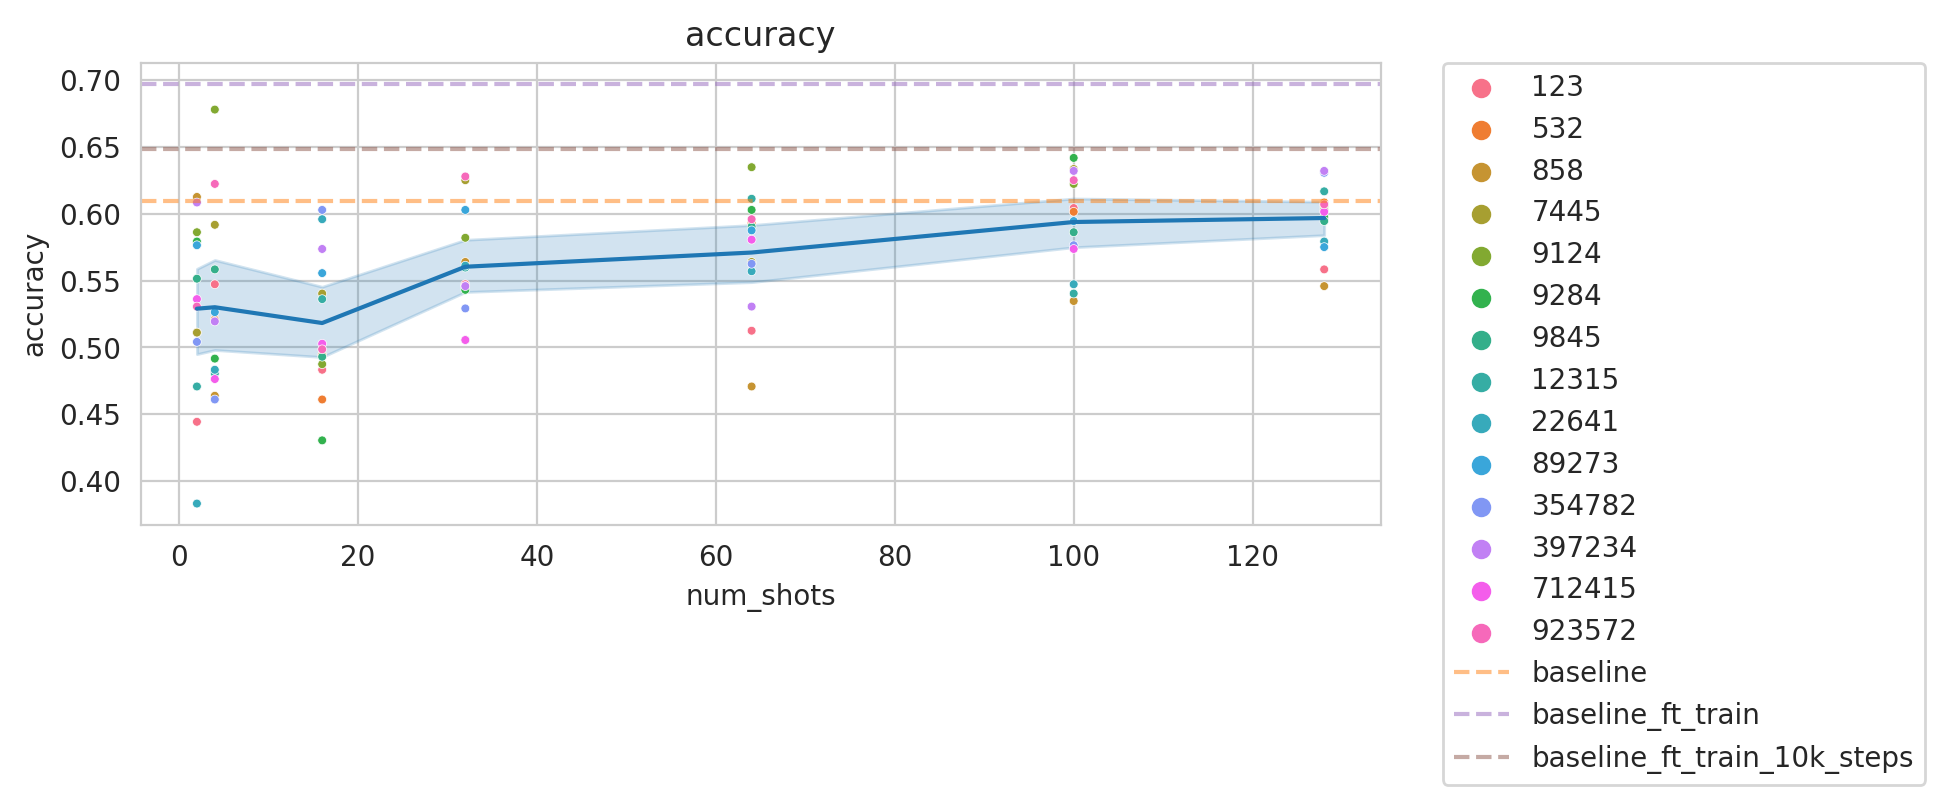

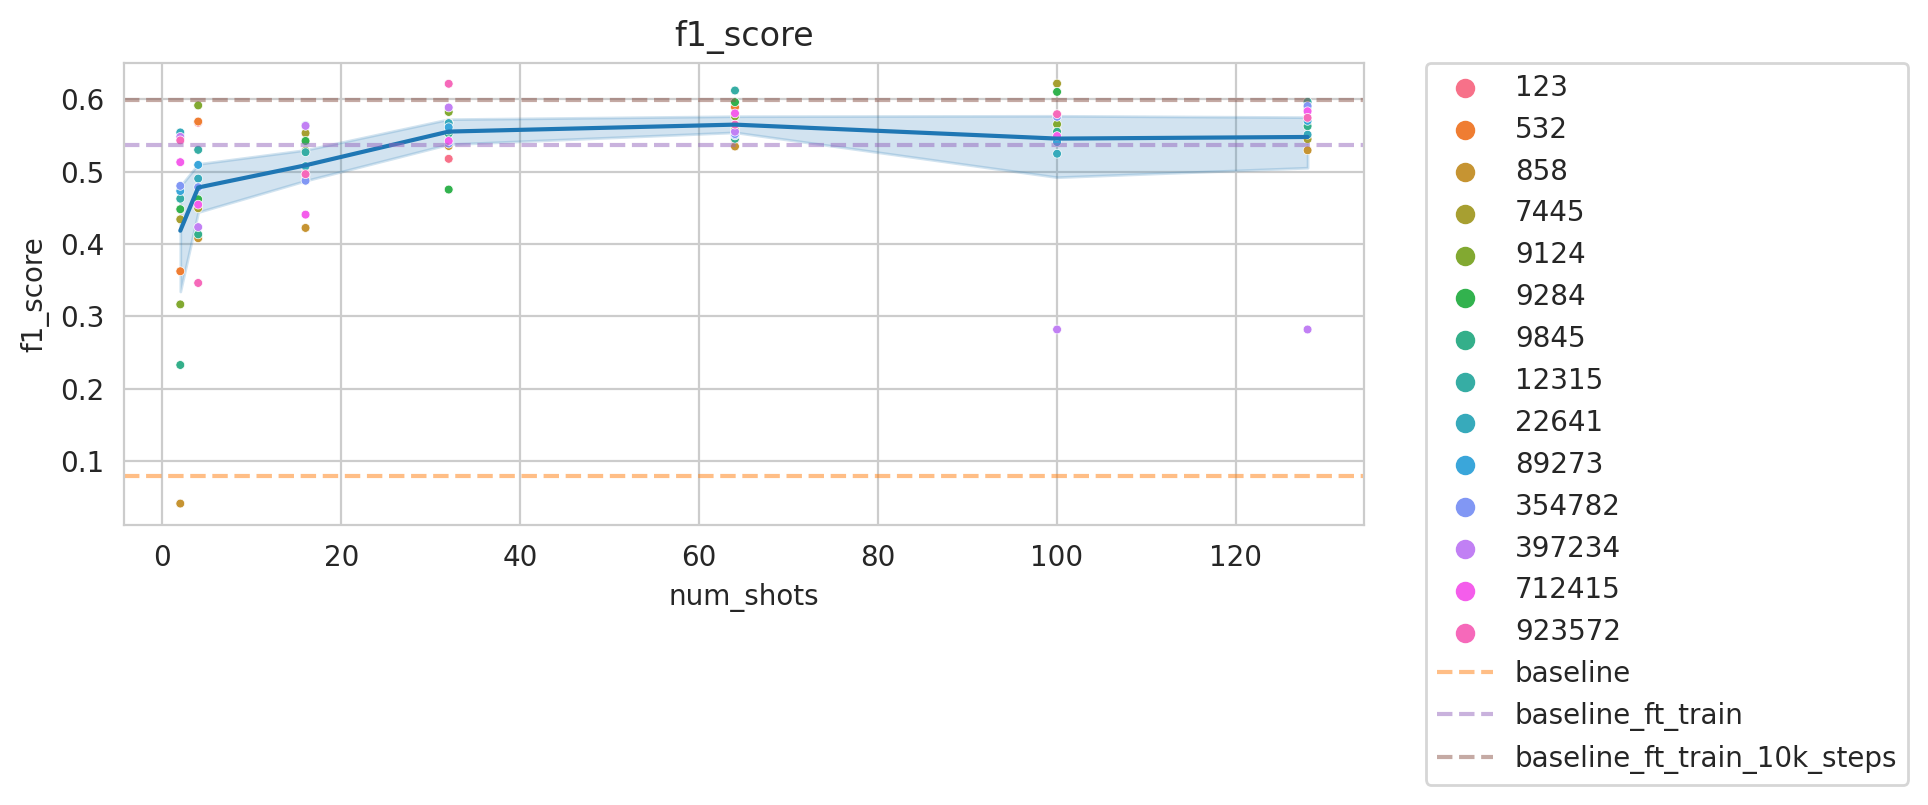

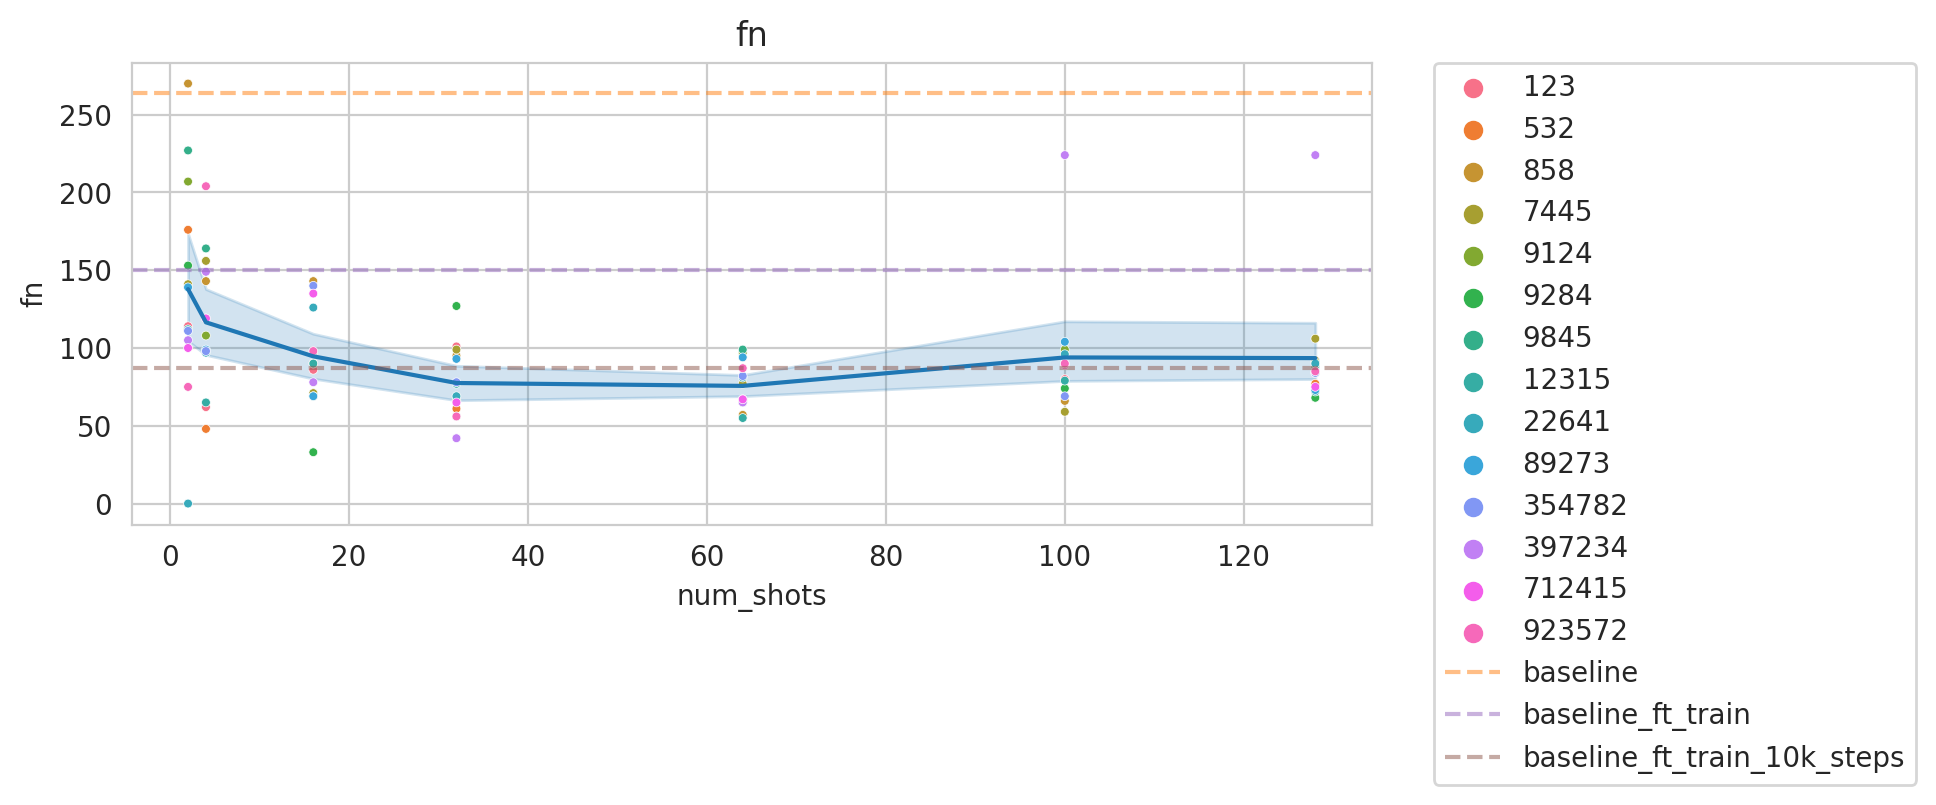

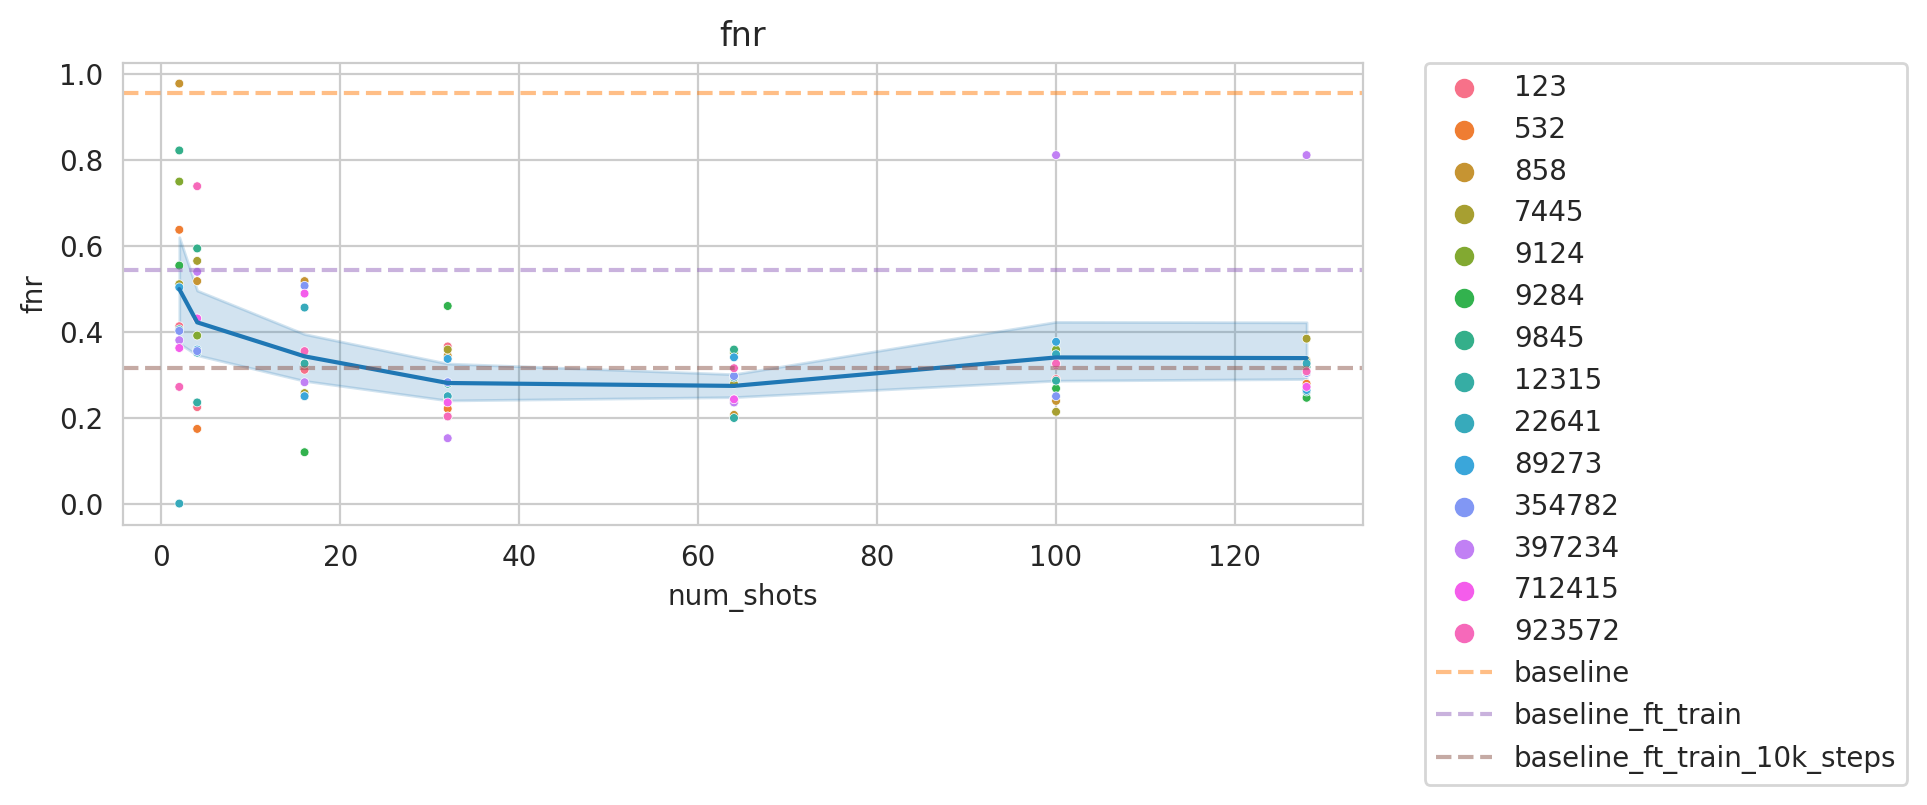

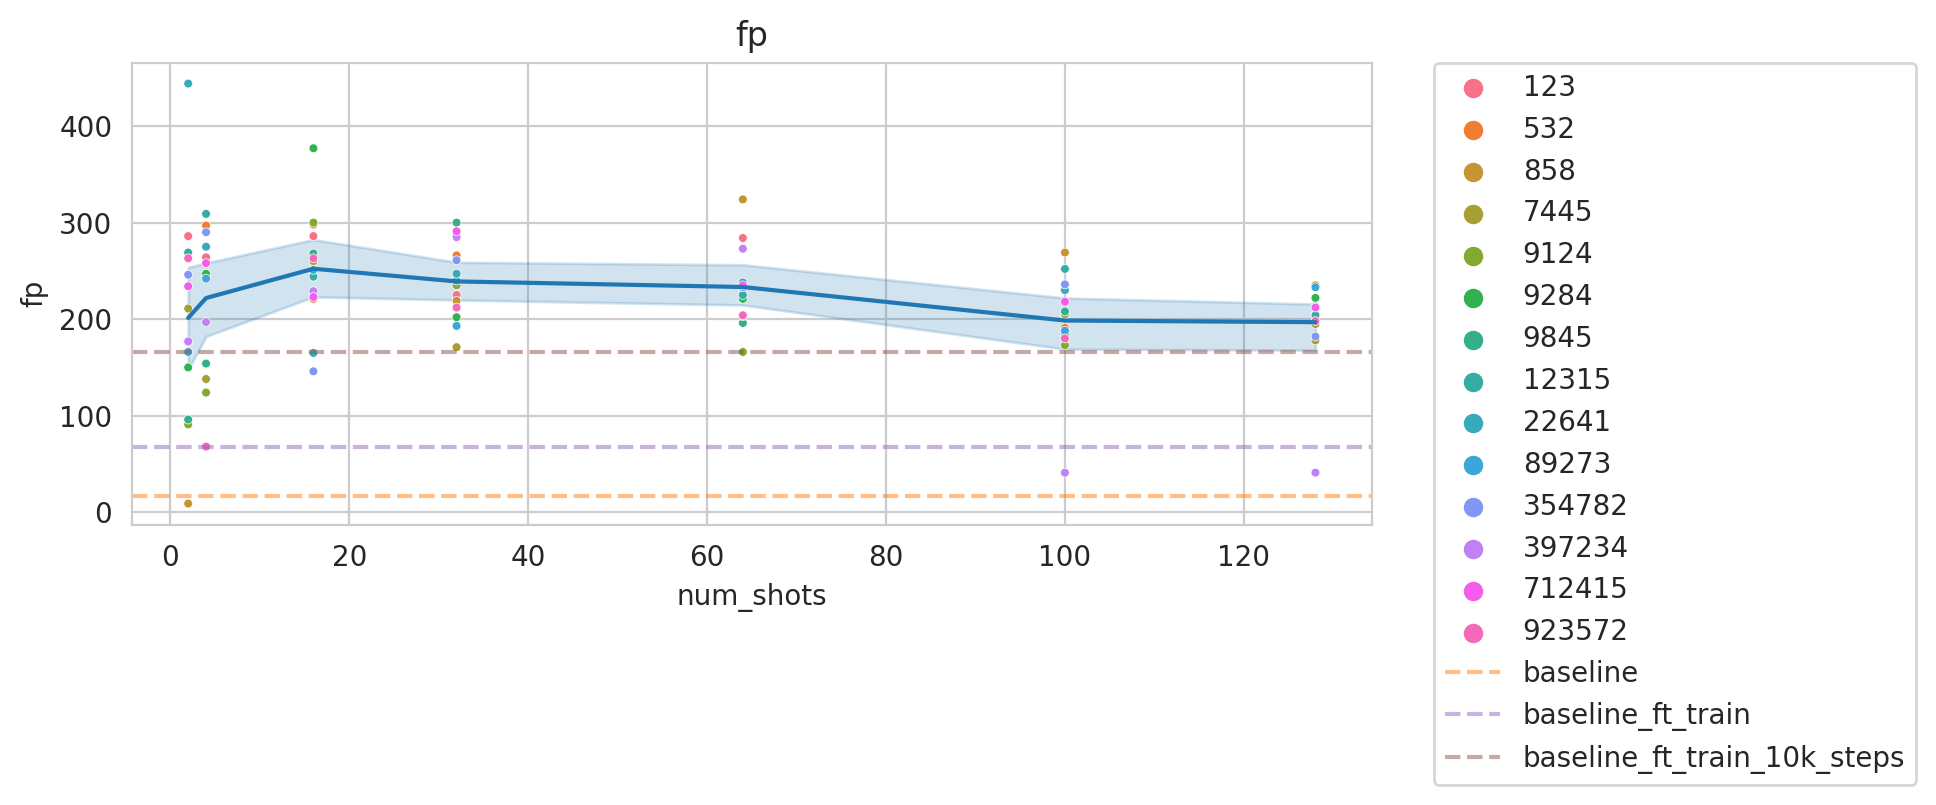

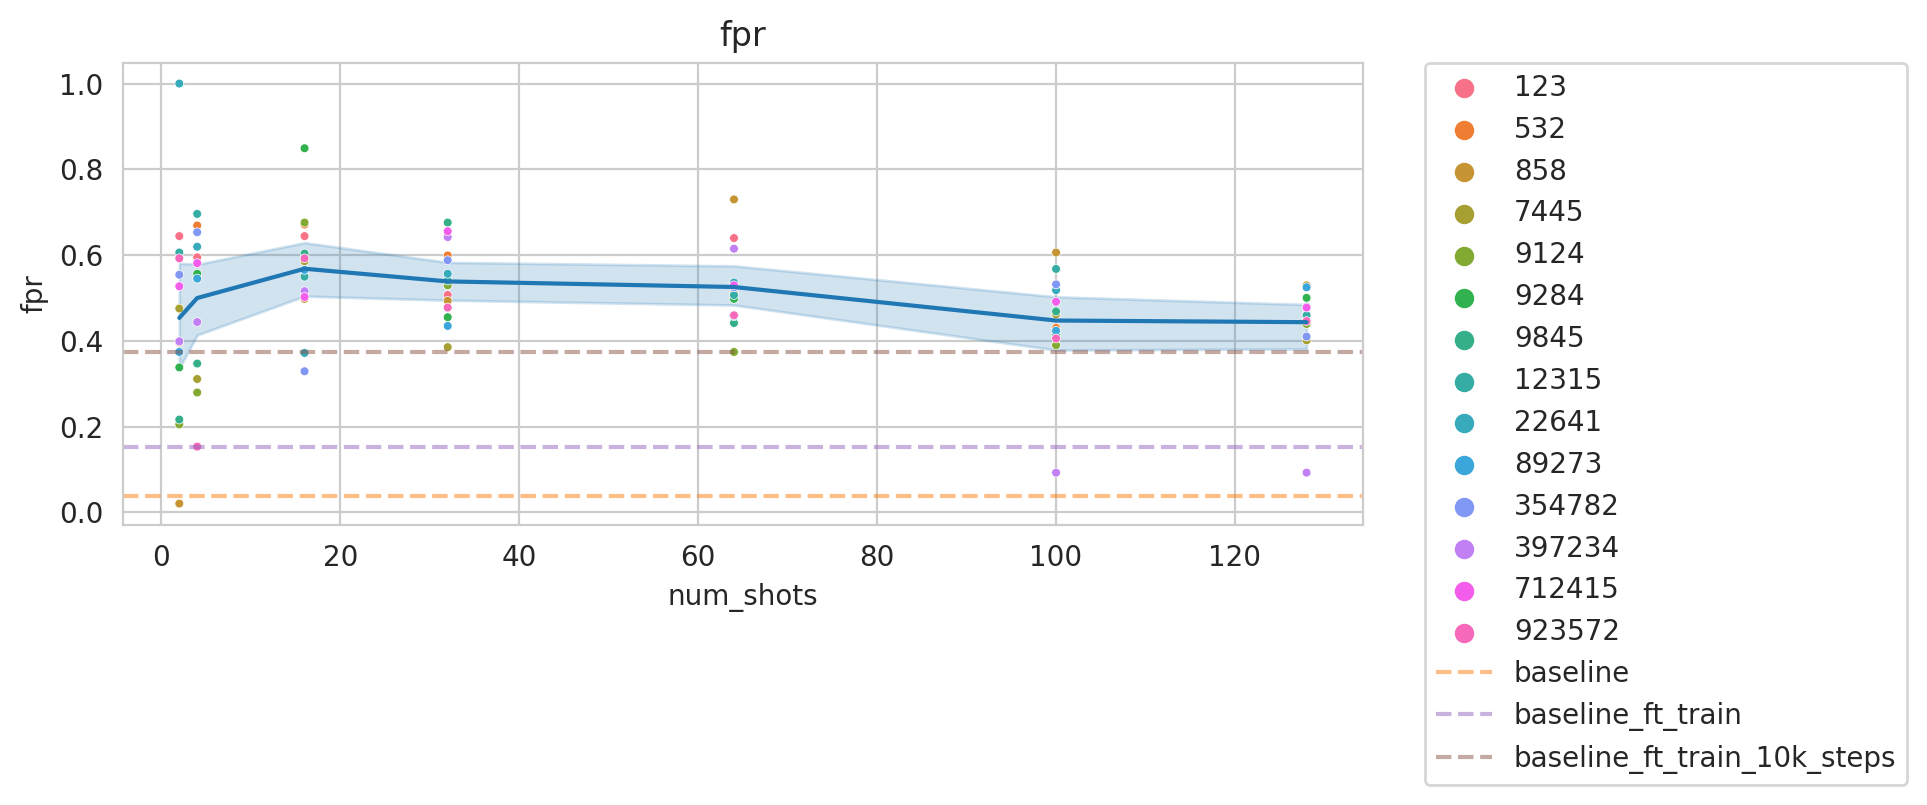

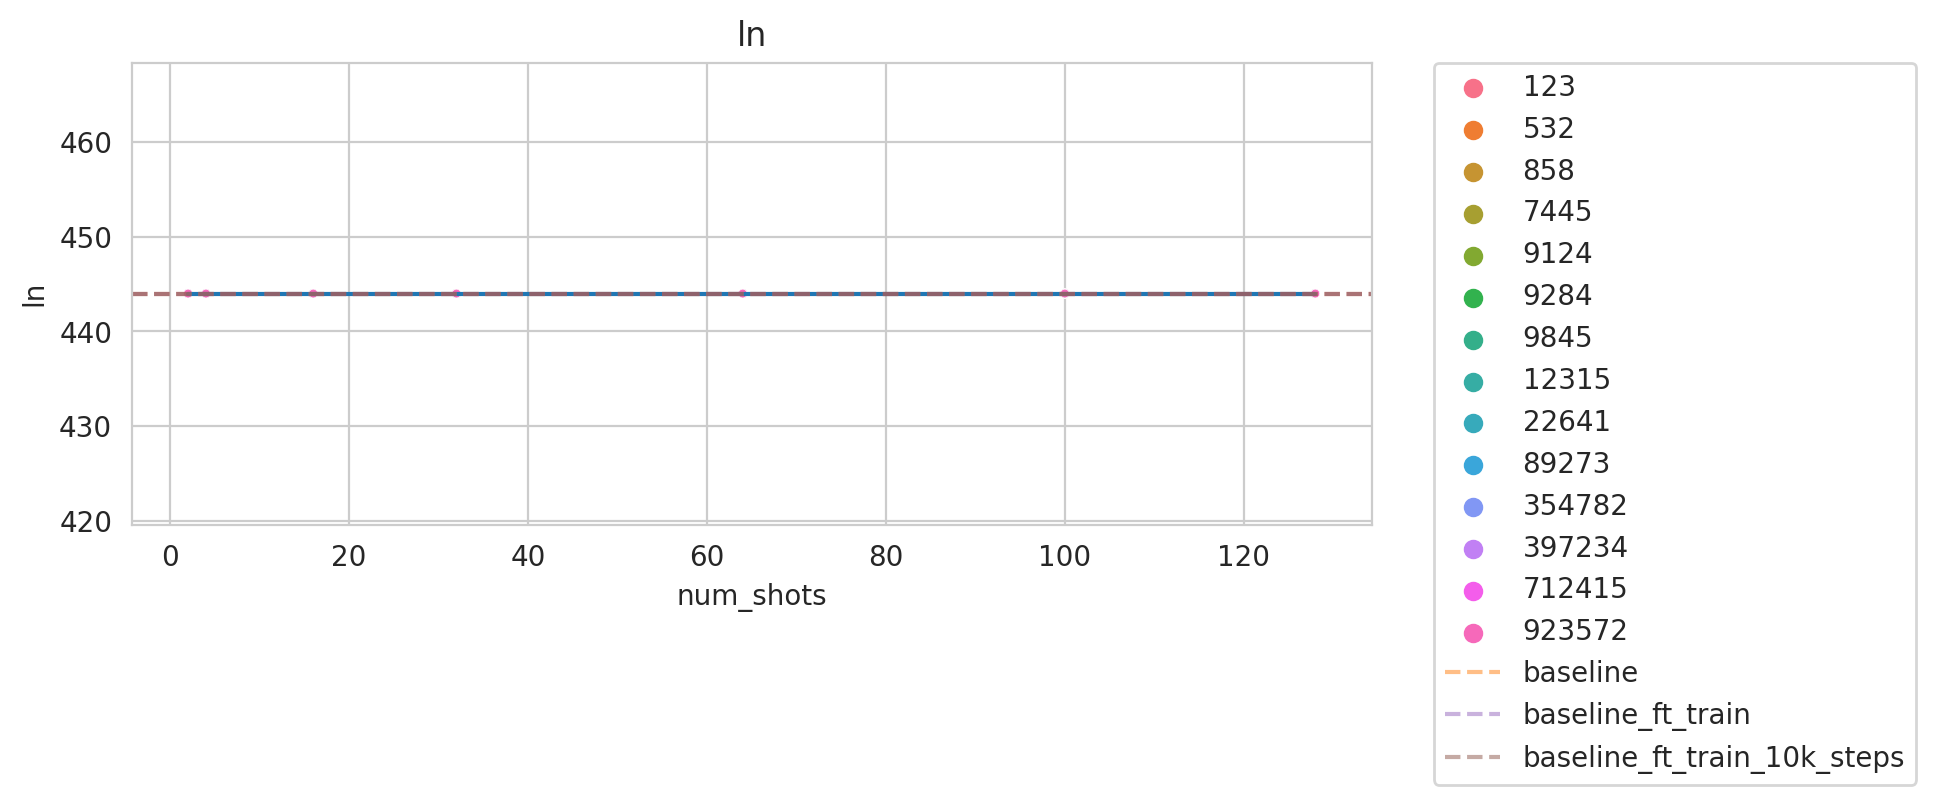

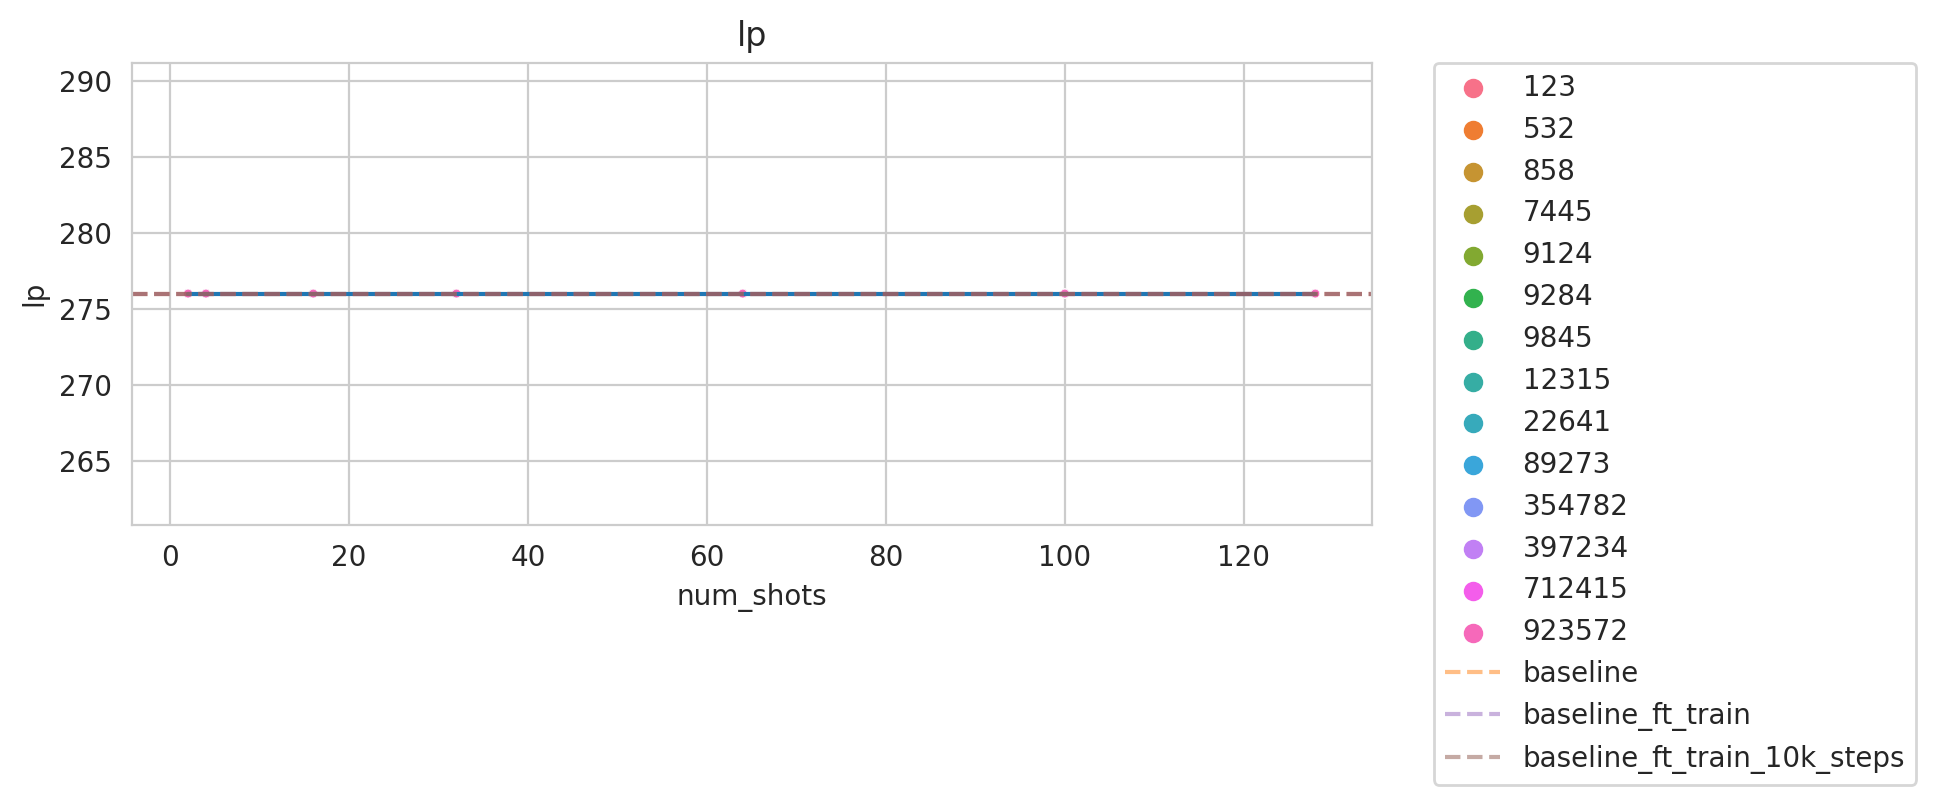

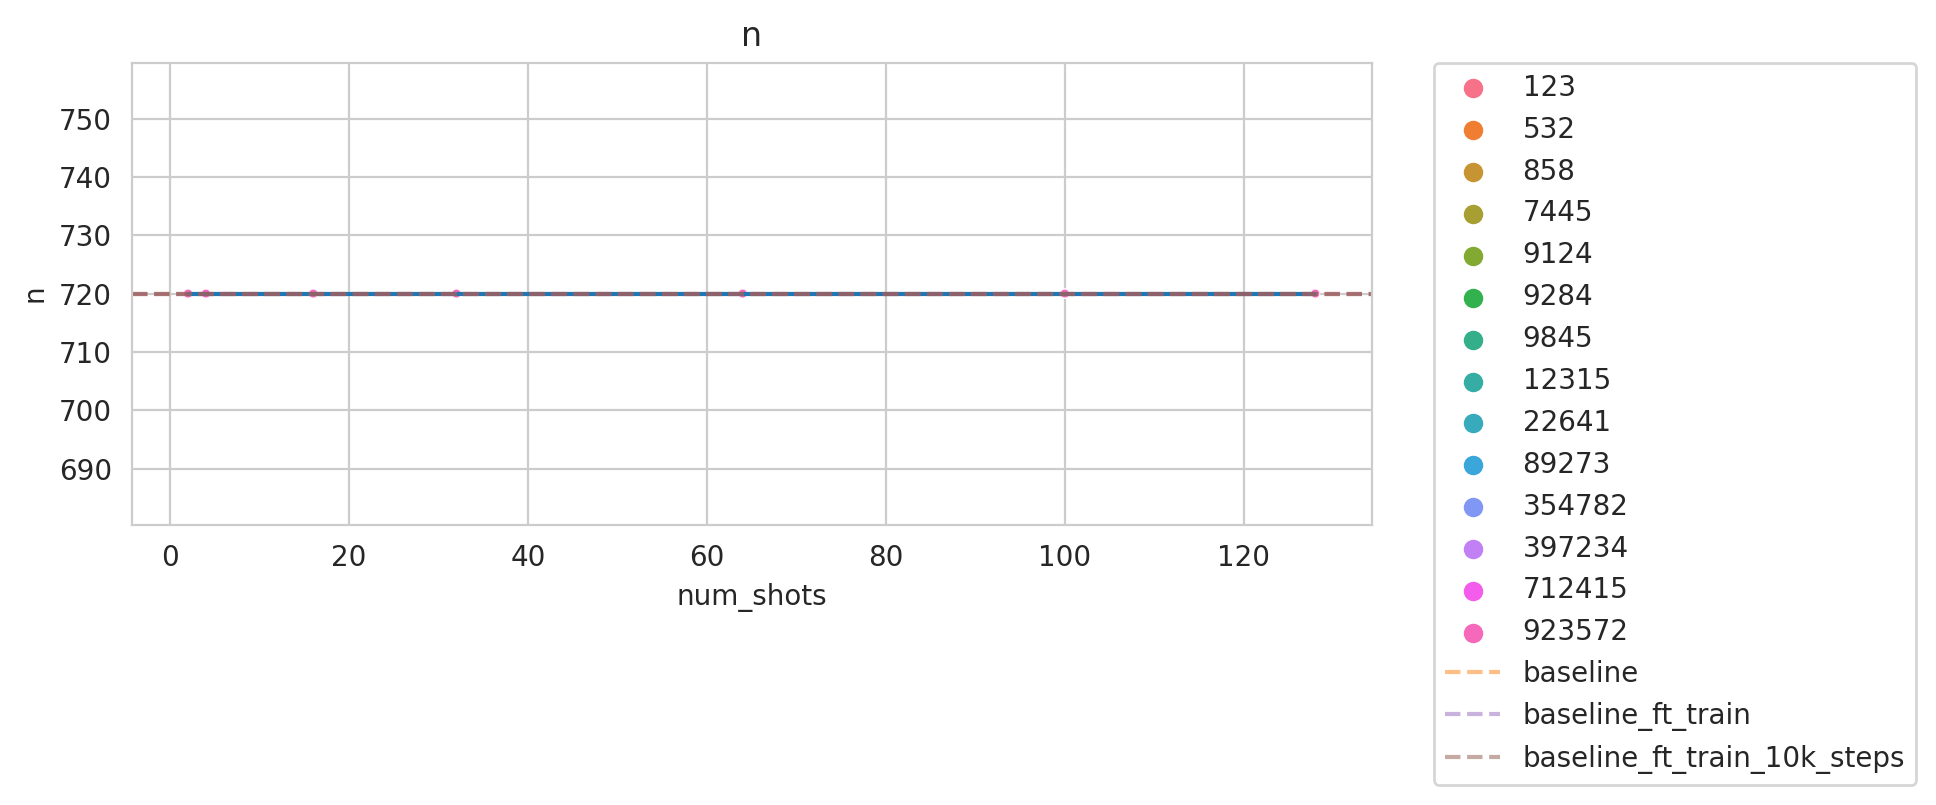

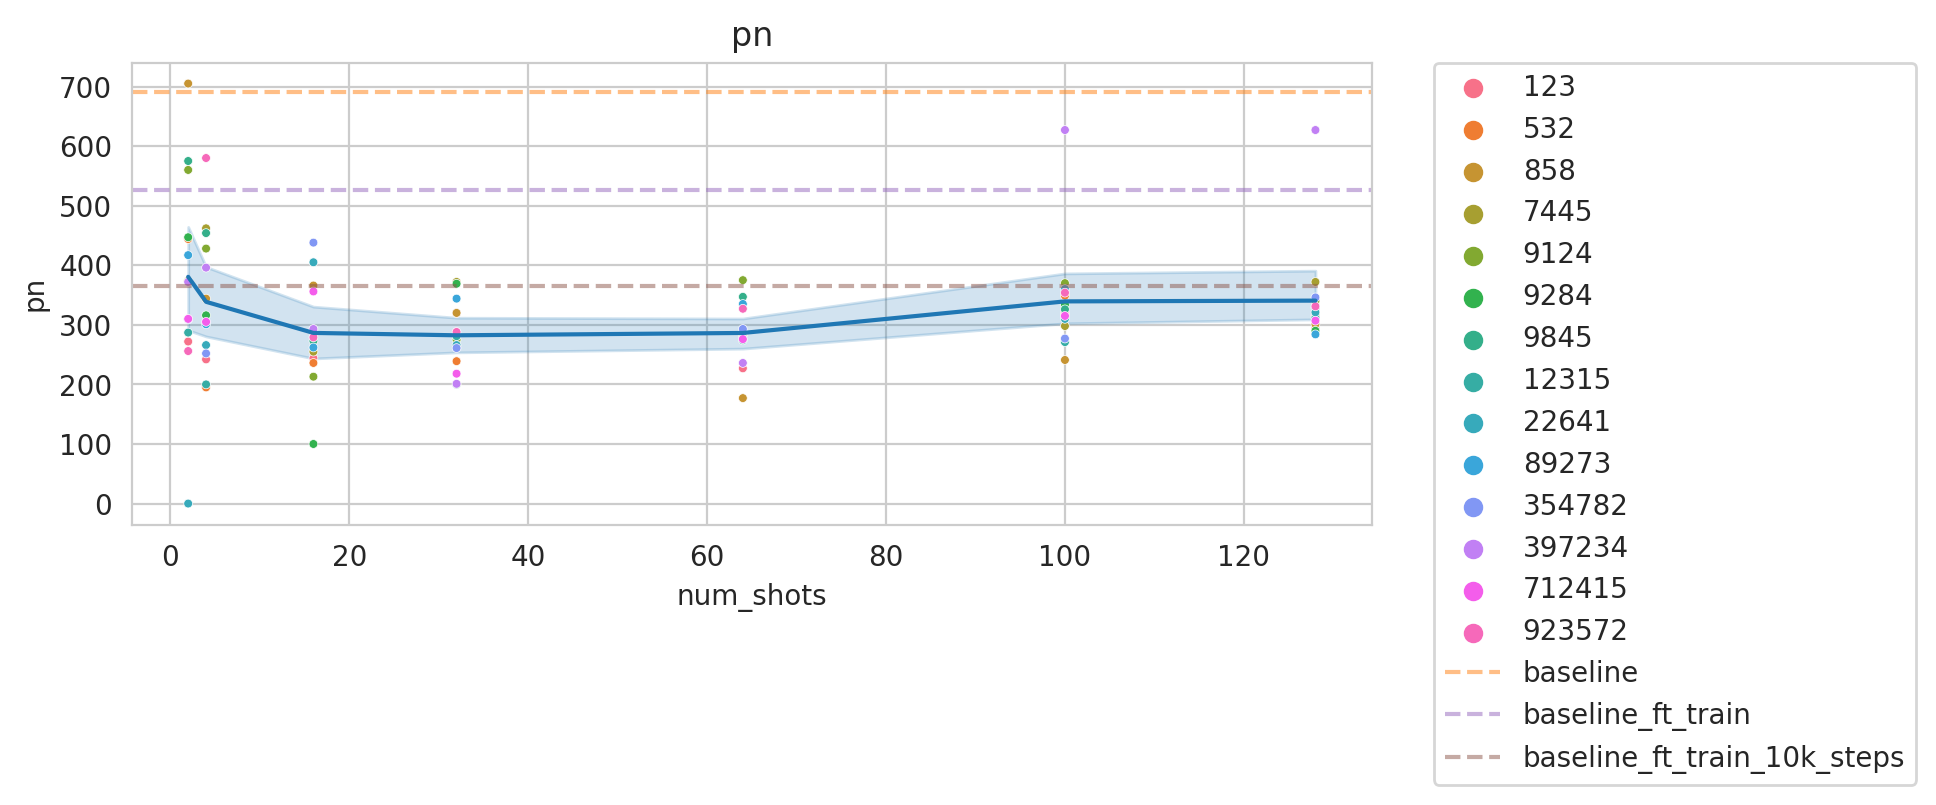

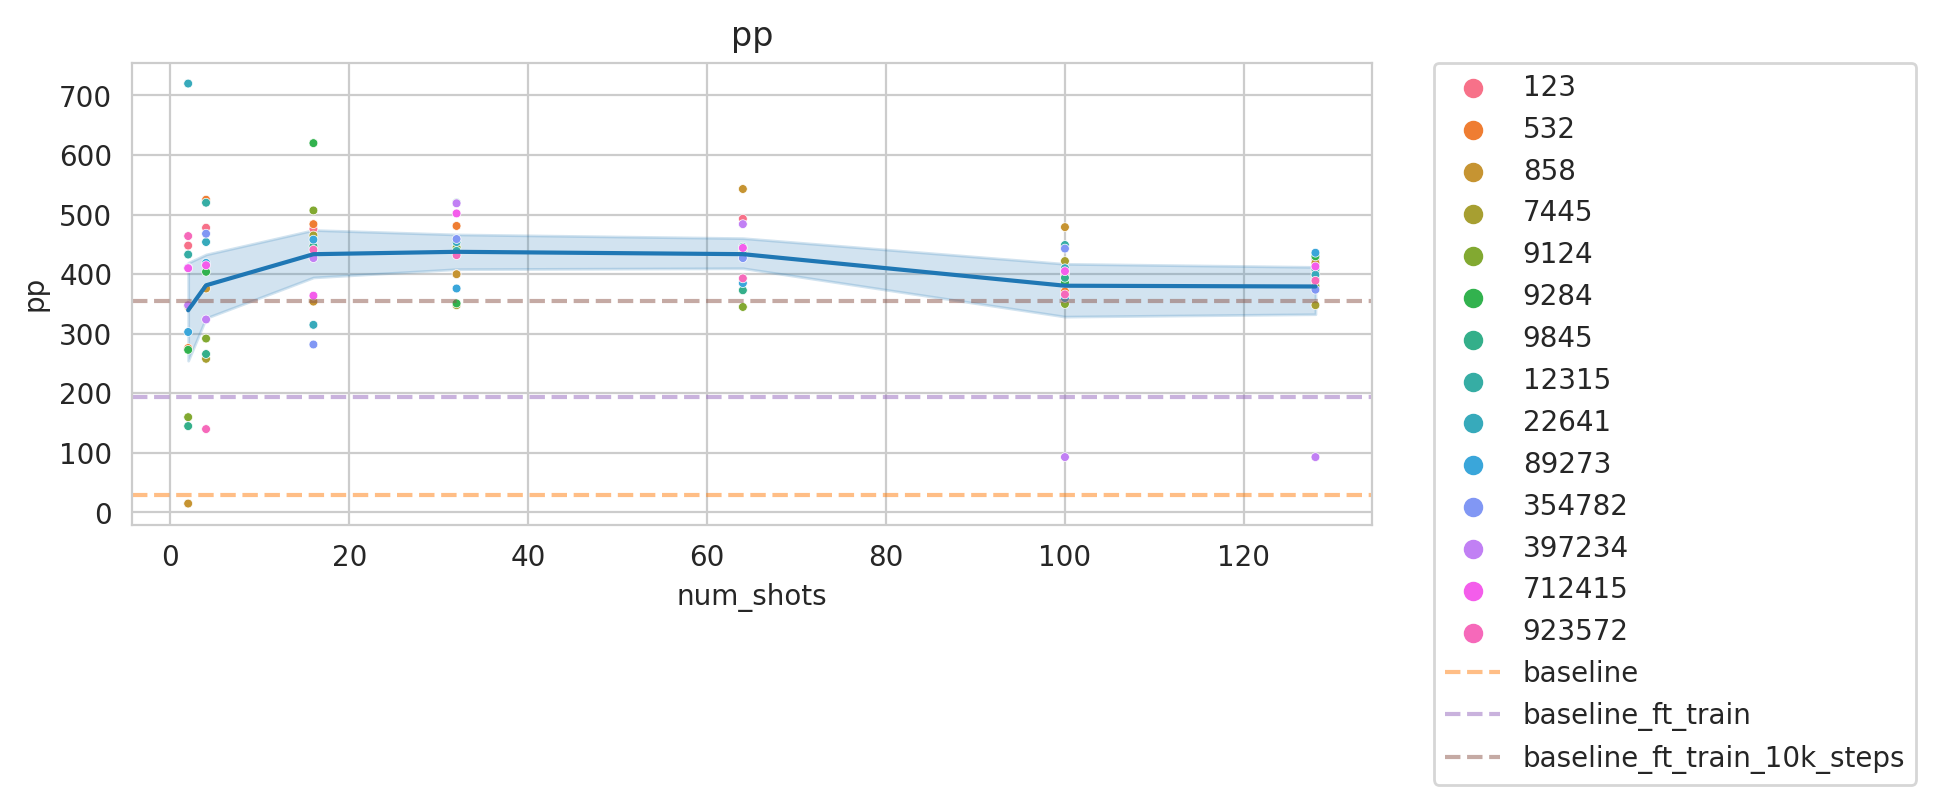

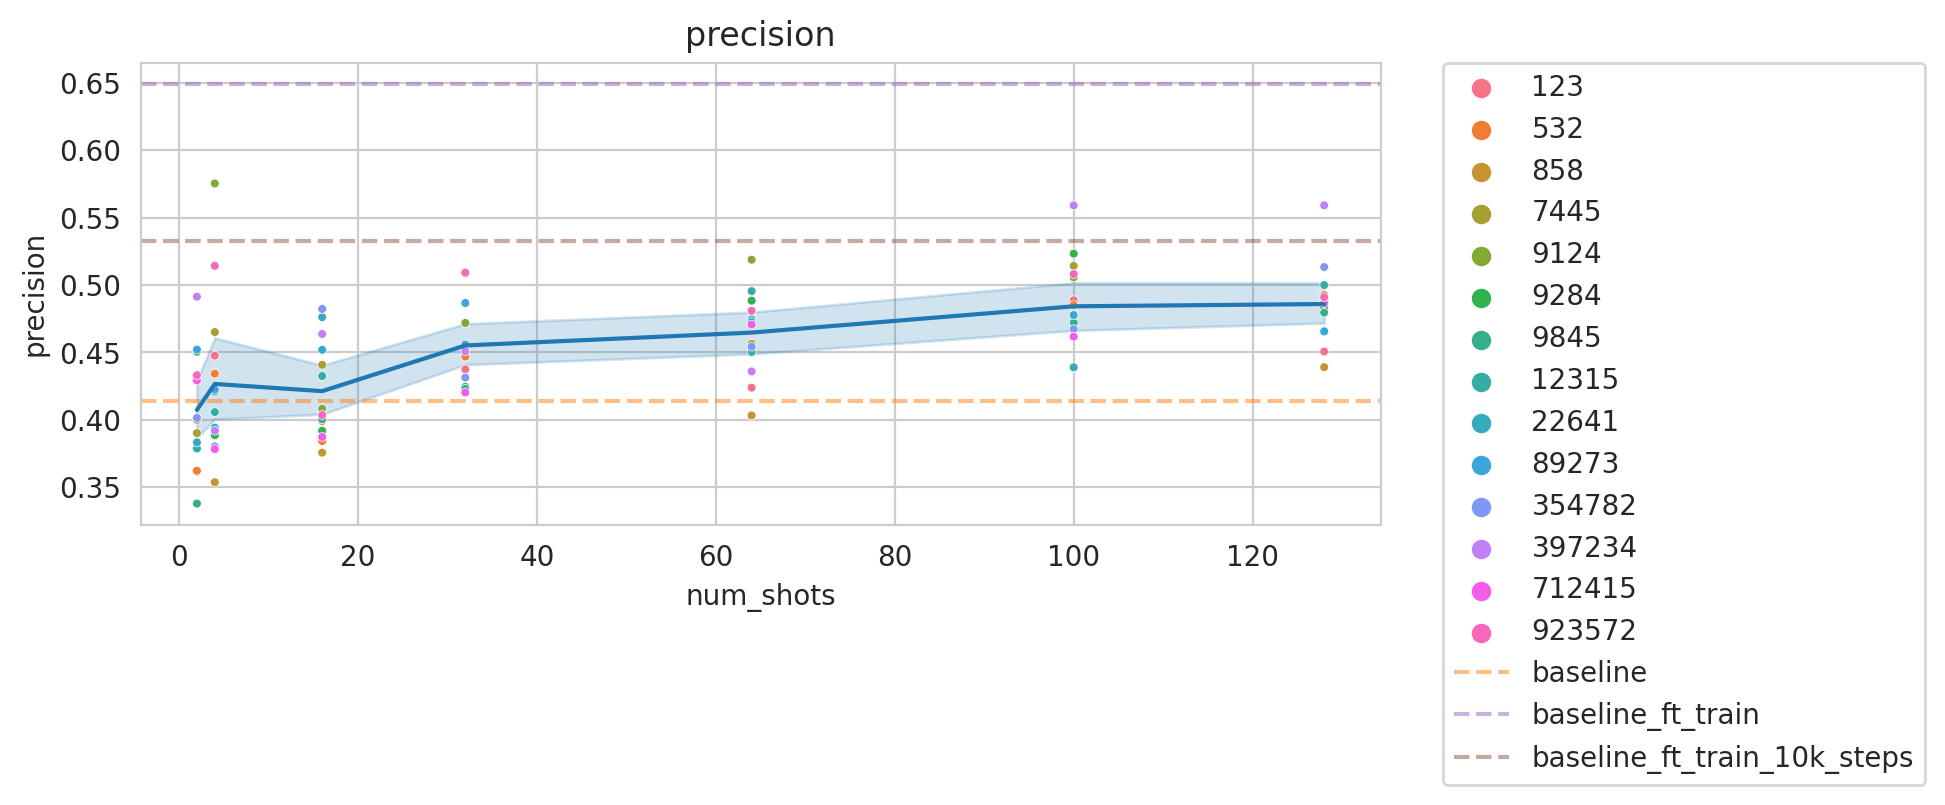

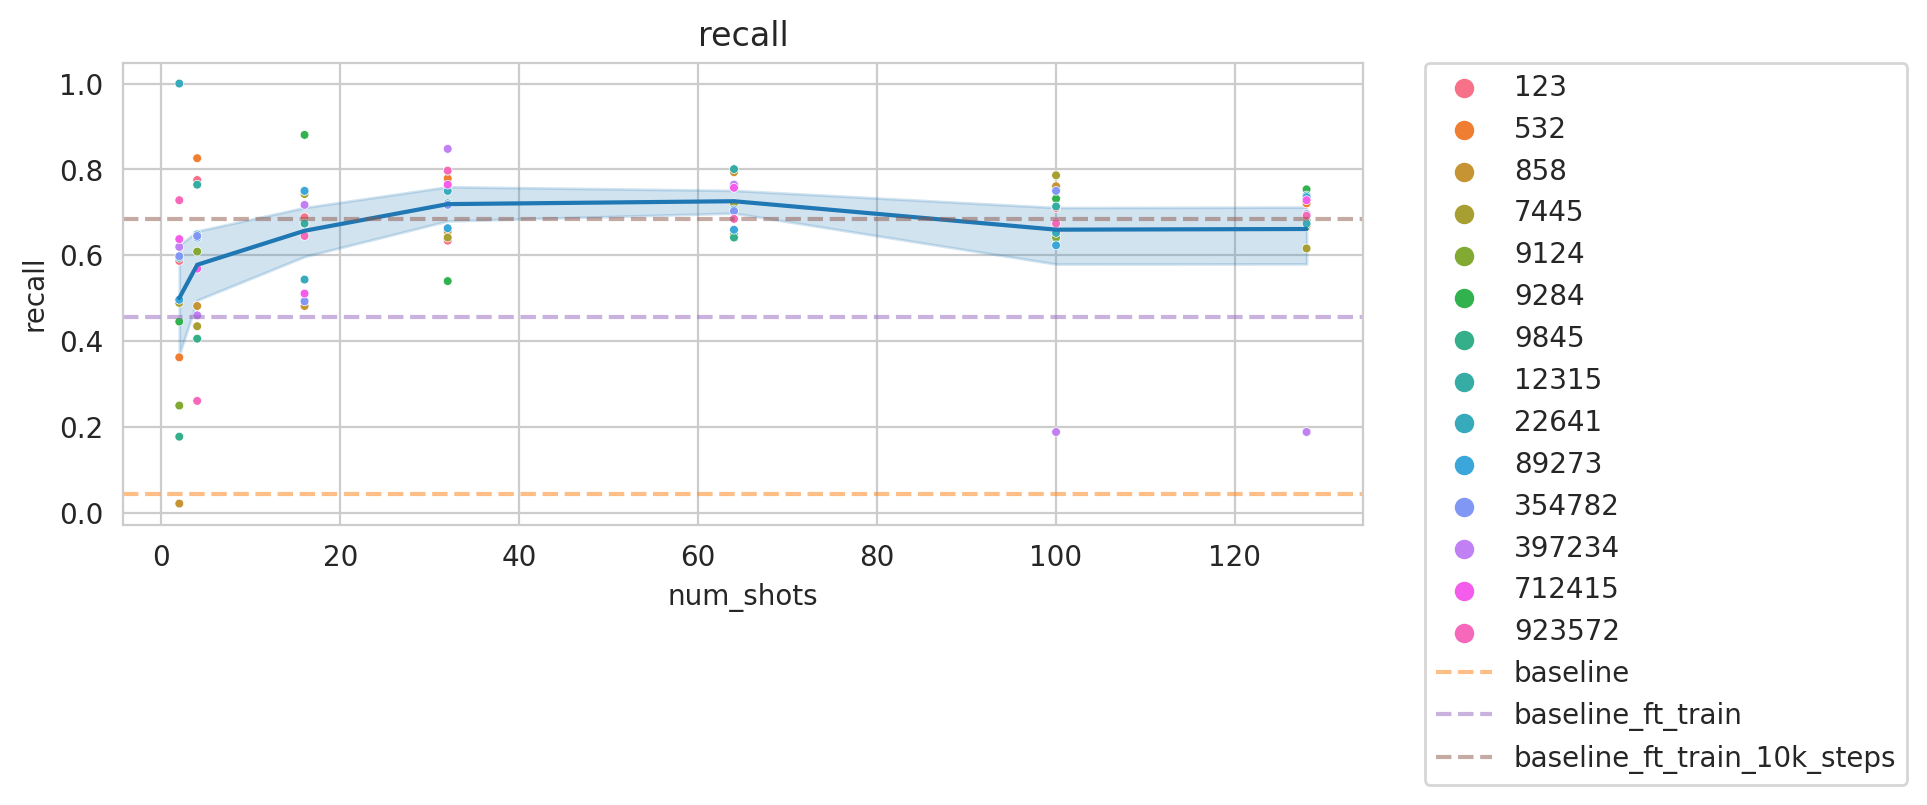

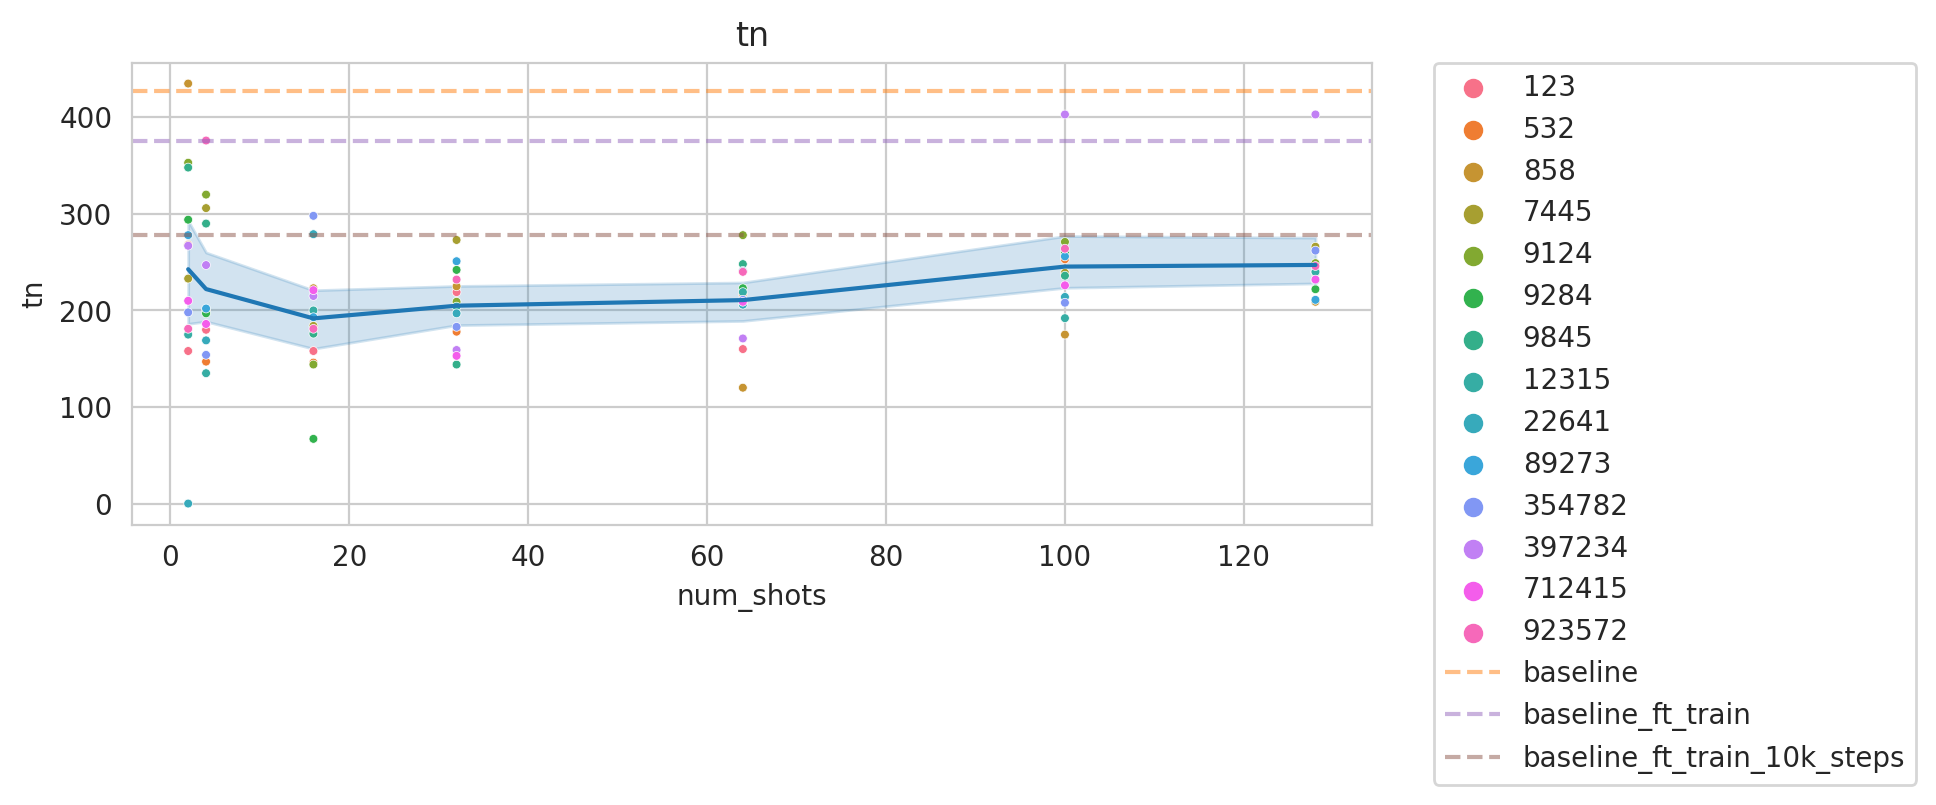

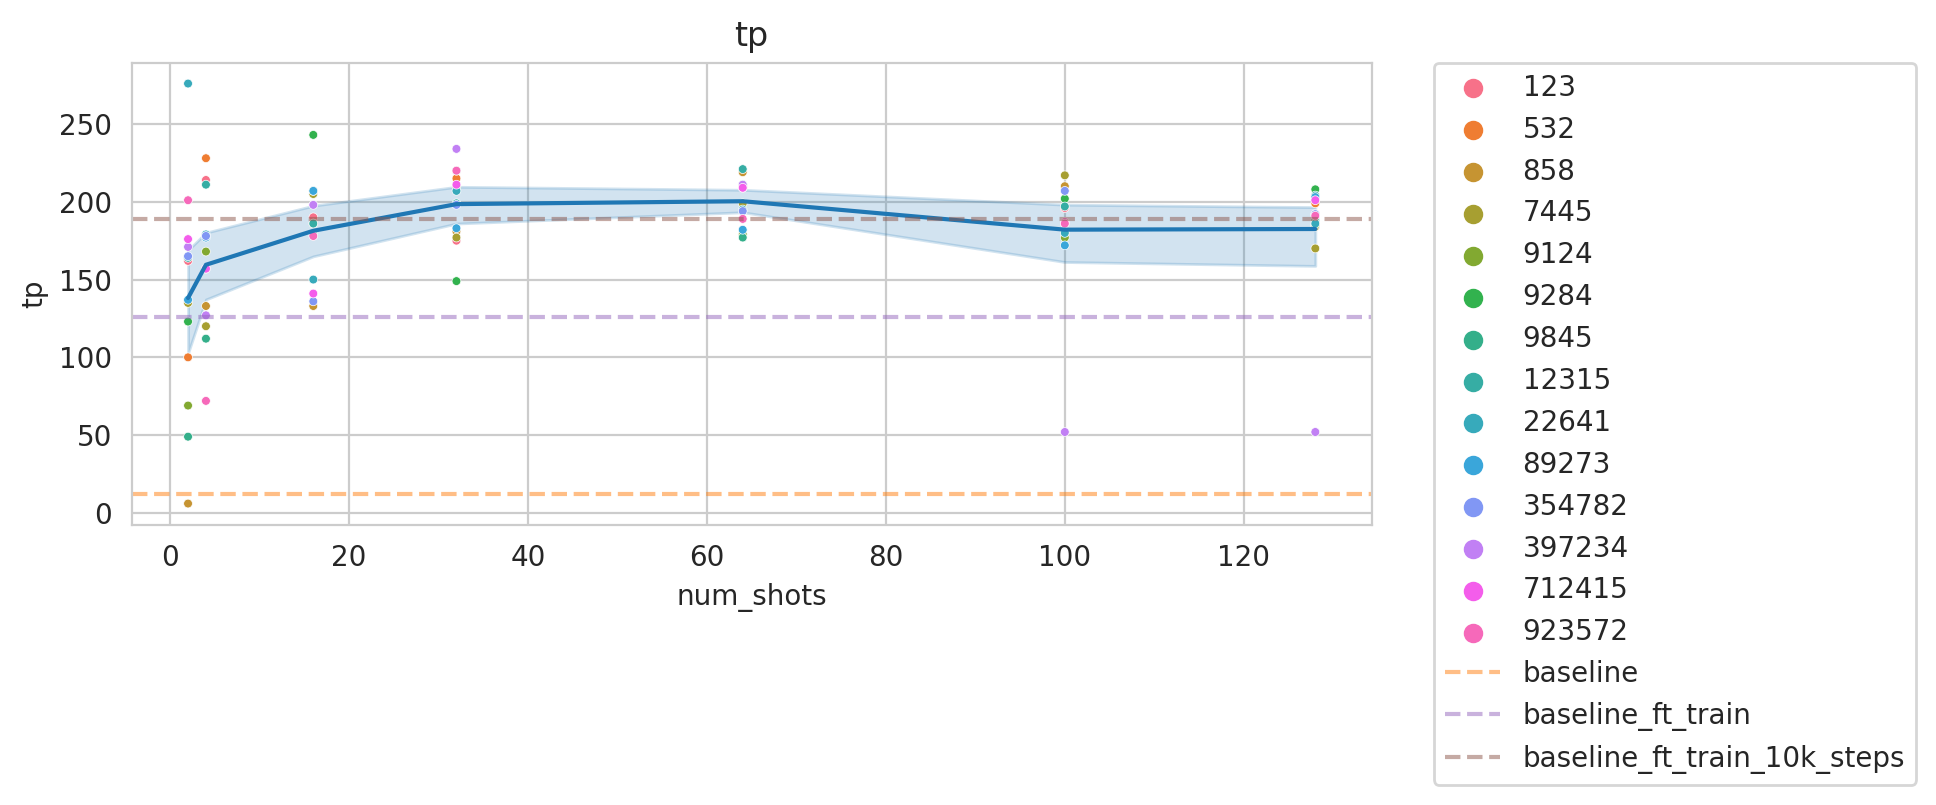

In [74]:
sns.set_style("whitegrid")
dev_metrics_kshot["seed_shots"] = dev_metrics_kshot["seed_shots"].apply(str) 

T0_BASELINES = sorted(dev_metrics_baselines["index"].unique())
COLOR_MAP = sns.color_palette(n_colors=len(T0_BASELINES)+1)

T0_COLORS = {baseline: COLOR_MAP[i+1] for i, baseline in enumerate(T0_BASELINES)}


for metric in sorted(dev_metrics_baselines.columns[1:]):
    plt.figure(figsize=(8, 3), dpi=200)
    sns.lineplot(data=dev_metrics_kshot, x="num_shots", y=metric)
    sns.scatterplot(data=dev_metrics_kshot, x="num_shots", y=metric, s=10, hue="seed_shots")
    
    # Plot T0 baselines
    for i, (baseline, value) in dev_metrics_baselines[["index", metric]].iterrows():
        if "ft_all" in baseline:
            continue
        plt.axhline(y=value, label=baseline, color=T0_COLORS[baseline], linestyle='--', alpha=0.5)
        # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')

    plt.title(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

### Shots

In [21]:
# 
ins_corrs_dev_kshot = pd.read_csv("./results/summ/REALSumm_2class_kshots_dev_inst_corrs.csv")
sys_corrs_dev_kshot = pd.read_csv("./results/summ/REALSumm_2class_kshots_dev_system_corrs.csv")

ins_corrs_dev_kshot["model"] = ins_corrs_dev_kshot["index"].apply(parse_model)
ins_corrs_dev_kshot["num_shots"] = ins_corrs_dev_kshot["index"].apply(parse_shots)
ins_corrs_dev_kshot["seed_shots"] = ins_corrs_dev_kshot["index"].apply(parse_seed)

sys_corrs_dev_kshot["model"] = sys_corrs_dev_kshot["index"].apply(parse_model)
sys_corrs_dev_kshot["num_shots"] = sys_corrs_dev_kshot["index"].apply(parse_shots)
sys_corrs_dev_kshot["seed_shots"] = sys_corrs_dev_kshot["index"].apply(parse_seed)

# 
ins_corrs_dev_baselines = pd.read_csv("./results/summ/REALSumm_2class_t0_baselines_dev_inst_corrs.csv")
sys_corrs_dev_baselines = pd.read_csv("./results/summ/REALSumm_2class_t0_baselines_dev_system_corrs.csv")

ins_metrics_dev = pd.read_csv("./results/summ/REALSumm_2class_dev_instance_corrs.csv")
sys_metrics_dev = pd.read_csv("./results/summ/REALSumm_2class_dev_system_corrs.csv")

In [22]:
SUMM_METRICS = [
    "rouge1_f", "rouge1_r", "rouge2_r",
    # "rouge2_f", "rougel_f",
    "bert_score_f",
    "mover_score",
    "prism_ref_hypo",
    # "bart_score_ref_hypo",
    # "bart_score_cnn_ref_hypo",
    "bart_score_para_ref_hypo",
]

SUMM_BASELINES = sorted(SUMM_METRICS)
COLOR_MAP_SUMM = sns.color_palette(n_colors=len(SUMM_BASELINES)+5)
SUMM_COLORS = {baseline: COLOR_MAP_SUMM[i+5] for i, baseline in enumerate(SUMM_BASELINES)}

In [23]:
SUMM_METRICS_INS_CORRS = ins_metrics_dev[ins_metrics_dev["index"].isin(SUMM_METRICS)]


In [24]:
ins_metrics_dev.sort_values("kendalltau", ascending=False).head()

index  pearsonr  spearmanr  kendalltau
8                     rouge1_r  0.544072   0.502784    0.407396
14                    rougel_r  0.536181   0.491268    0.400337
20  bart_score_cnn_hypo_ref_de  0.523225   0.503853    0.397935
31     bart_score_cnn_hypo_ref  0.517203   0.490905    0.388224
19  bart_score_cnn_hypo_ref_en  0.516989   0.490462    0.387891

In [25]:
ins_metrics_dev.sort_values("kendalltau", ascending=True).head()

index  pearsonr  spearmanr  kendalltau
27       bart_score_ref_hypo -0.074409  -0.054076   -0.040898
7             prism_src_hypo  0.069174   0.074926    0.063020
30   bart_score_cnn_src_hypo  0.082338   0.103455    0.079724
25       bart_score_src_hypo  0.137061   0.126972    0.091720
35  bart_score_para_src_hypo  0.150831   0.149253    0.107353

In [26]:
sys_metrics_dev.sort_values("kendalltau", ascending=False).head()

index  pearsonr  spearmanr  kendalltau
11                    rouge2_r    0.8979     0.8948      0.7246
14                    rougel_r    0.8444     0.8600      0.6594
8                     rouge1_r    0.8510     0.8417      0.6304
36    bart_score_para_hypo_ref    0.7895     0.8070      0.6159
20  bart_score_cnn_hypo_ref_de    0.7773     0.7948      0.6087

In [27]:
sys_metrics_dev.sort_values("kendalltau", ascending=True).head()

index  pearsonr  spearmanr  kendalltau
27  bart_score_ref_hypo   -0.2882    -0.3165     -0.2319
15             rougel_p   -0.1828    -0.1757     -0.1304
9              rouge1_p   -0.1355    -0.1704     -0.1232
0          bert_score_p    0.1775     0.0096      0.0072
12             rouge2_p    0.0895     0.0670      0.0435

In [28]:
SUMM_METRICS_SYS_CORRS = sys_metrics_dev[sys_metrics_dev["index"].isin(SUMM_METRICS)]
SUMM_METRICS_SYS_CORRS

index  pearsonr  spearmanr  kendalltau
2               bert_score_f    0.4013     0.2887      0.2029
3                mover_score    0.4277     0.3696      0.2319
4             prism_ref_hypo    0.5196     0.5661      0.3986
8                   rouge1_r    0.8510     0.8417      0.6304
10                  rouge1_f    0.5489     0.4870      0.3478
11                  rouge2_r    0.8979     0.8948      0.7246
37  bart_score_para_ref_hypo    0.3775     0.2591      0.1739

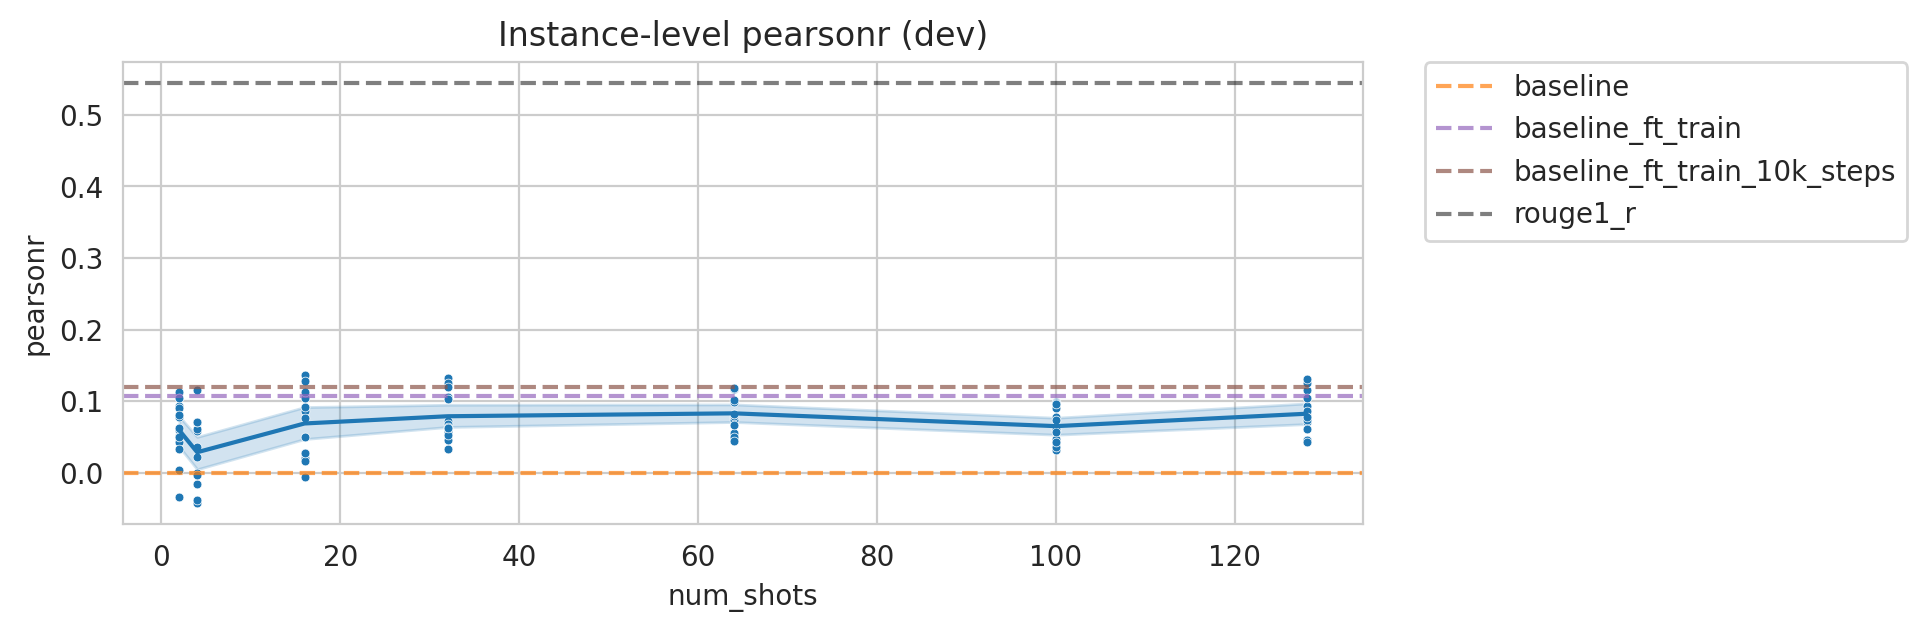

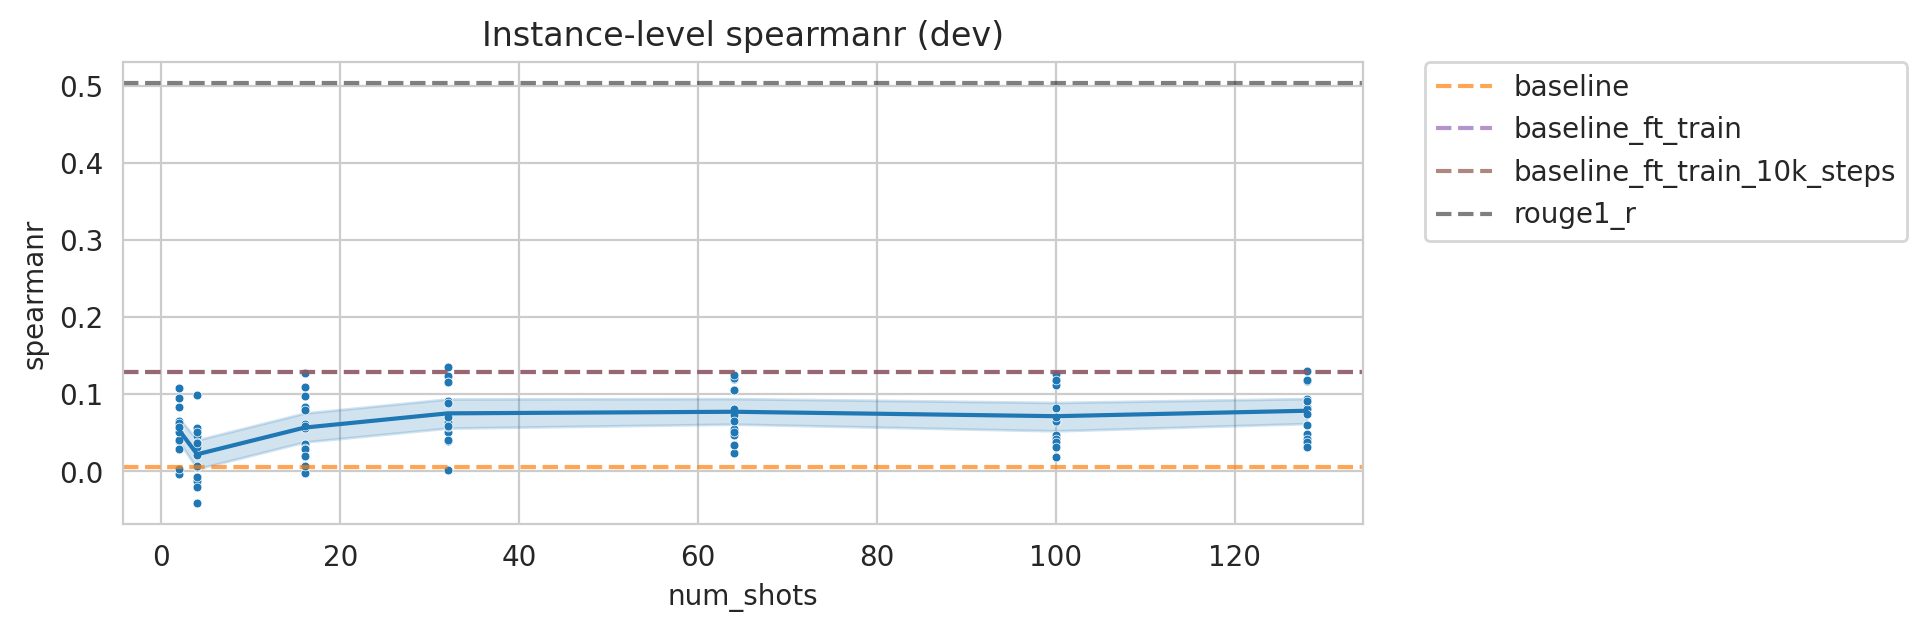

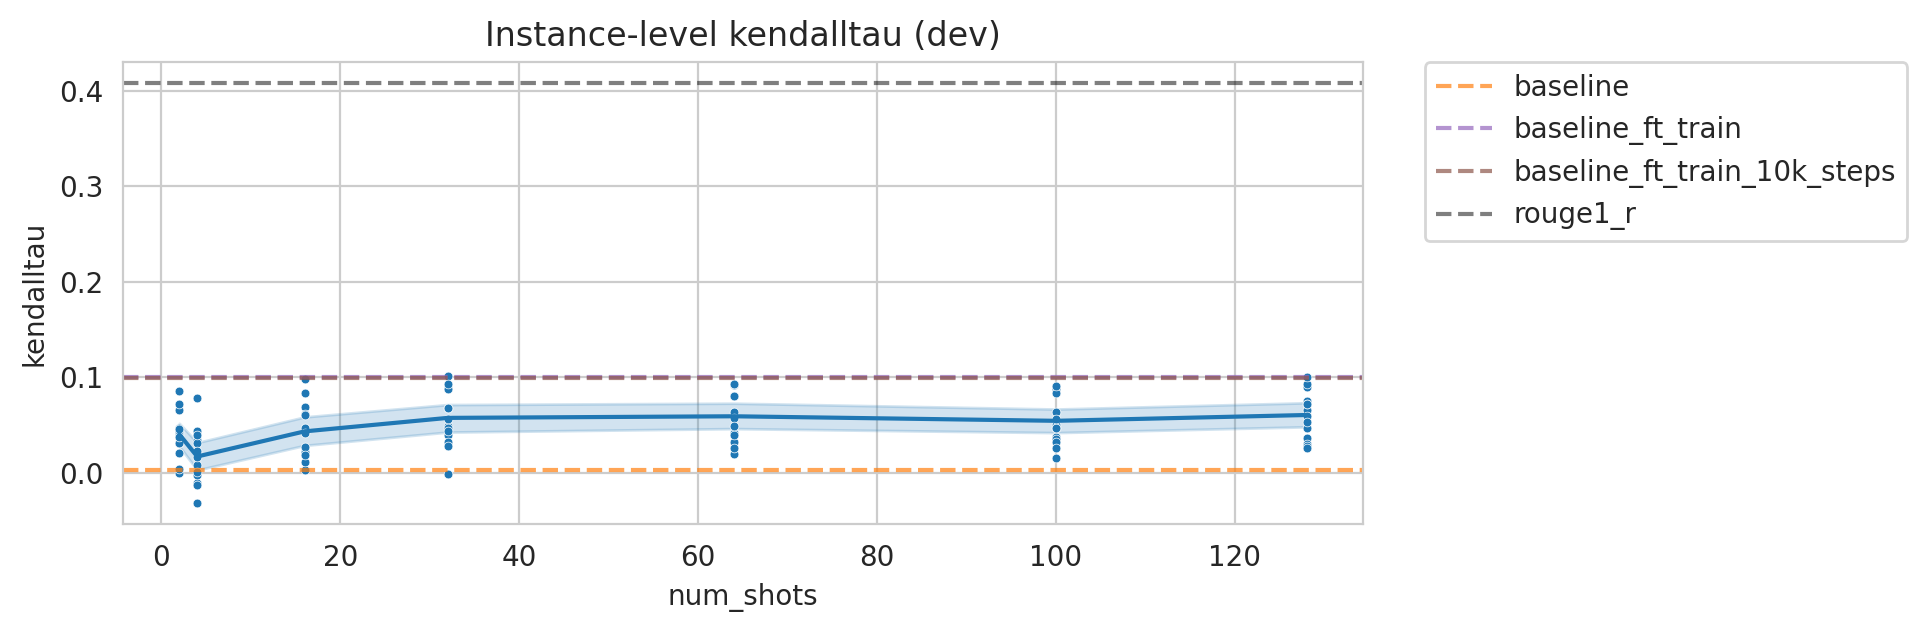

In [29]:
for metric in ("pearsonr", "spearmanr", "kendalltau"):
    plt.figure(figsize=(8, 3), dpi=200)
    sns.lineplot(data=ins_corrs_dev_kshot, x="num_shots", y=metric)
    sns.scatterplot(data=ins_corrs_dev_kshot, x="num_shots", y=metric, s=10)
    
    # Plot T0 baselines
    for i, (baseline, value) in ins_corrs_dev_baselines[["index", metric]].iterrows():
        if "ft_all" in baseline:
            continue
        plt.axhline(y=value, label=baseline, color=T0_COLORS[baseline], linestyle='--', alpha=0.7)
        # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')

    # Plot metrics (max and lowest)
    for i, (baseline, value) in SUMM_METRICS_INS_CORRS[["index", metric]].iterrows():
        if baseline == "rouge1_r":
            plt.axhline(y=np.abs(value), label=baseline, color="black", alpha=0.5, linestyle='--')
        # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')

        
    plt.title(f"Instance-level {metric} (dev)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

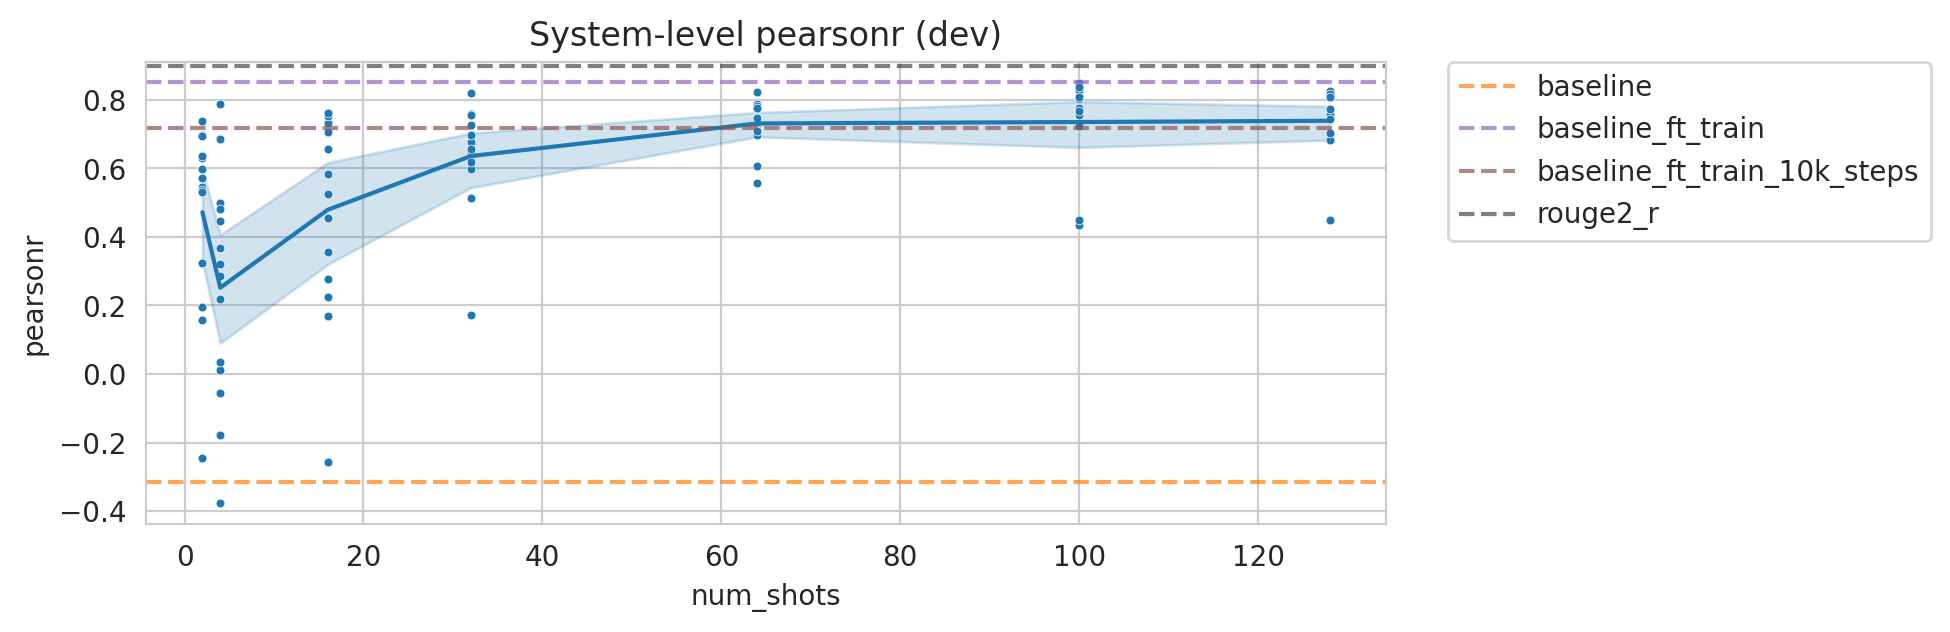

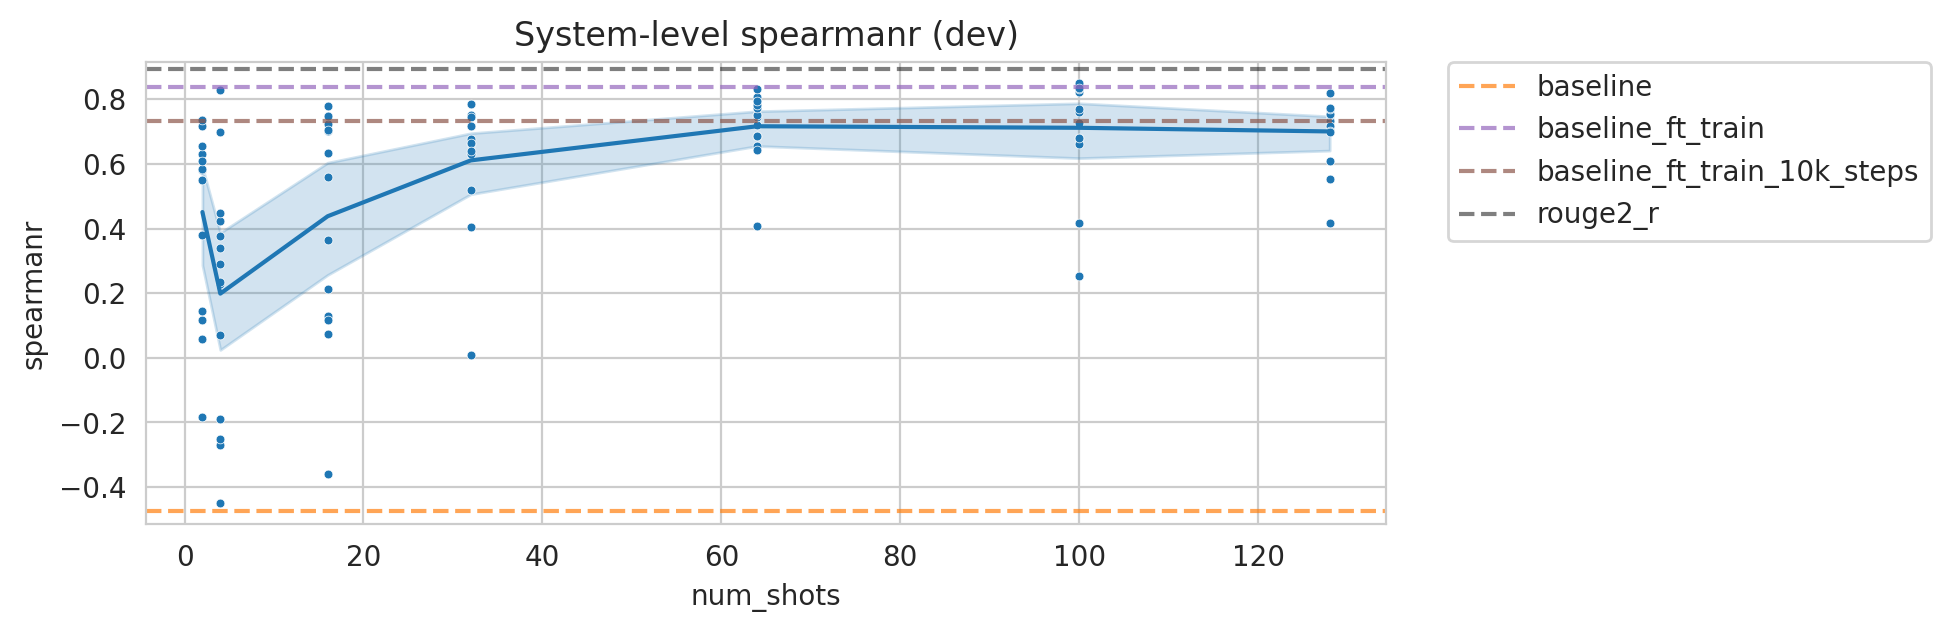

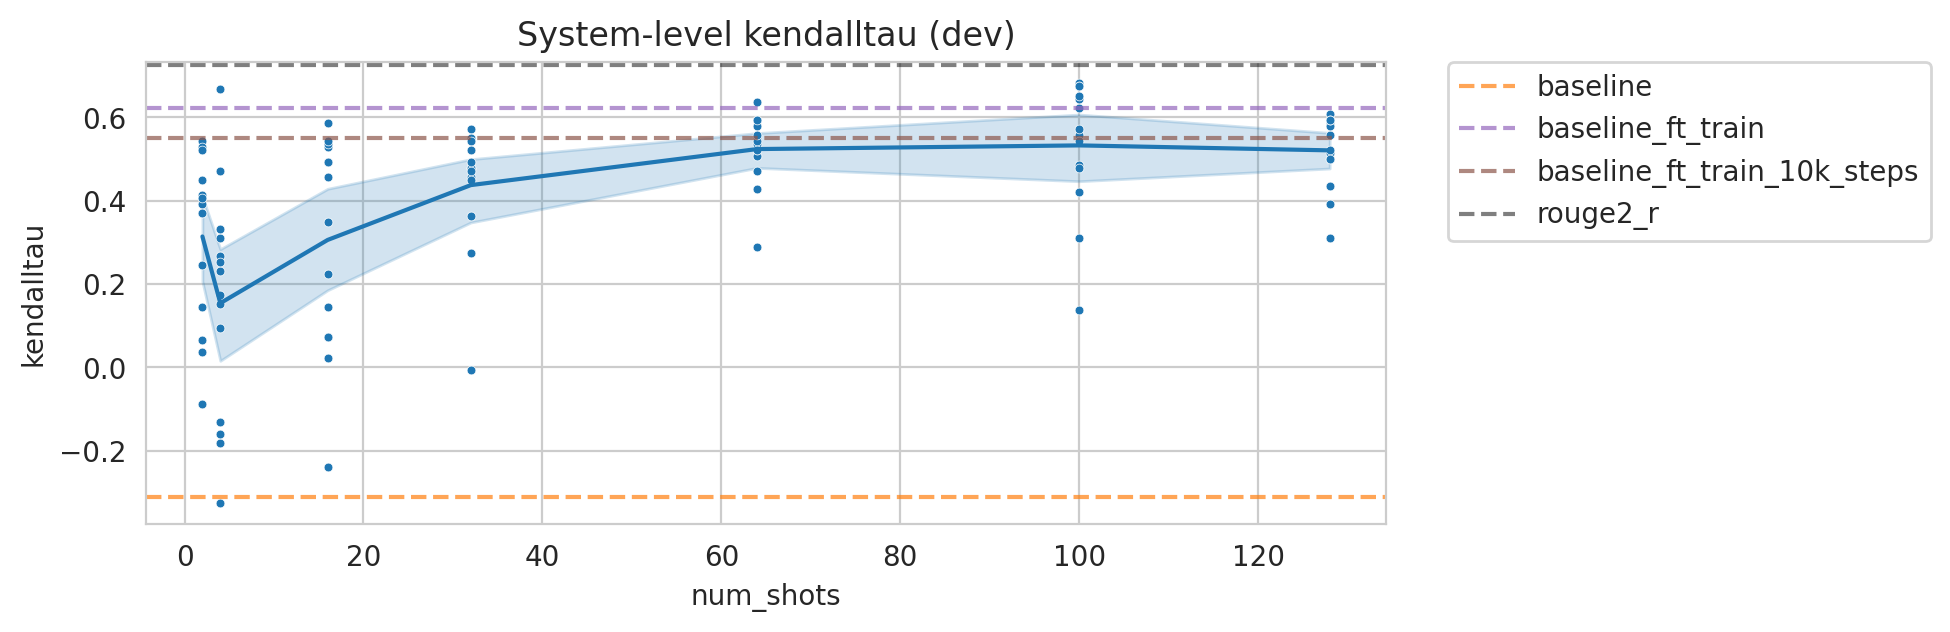

In [30]:
for metric in ("pearsonr", "spearmanr", "kendalltau"):
    plt.figure(figsize=(8, 3), dpi=200)
    sns.lineplot(data=sys_corrs_dev_kshot, x="num_shots", y=metric)
    sns.scatterplot(data=sys_corrs_dev_kshot, x="num_shots", y=metric, s=10)
    
    # Plot T0 baselines
    for i, (baseline, value) in sys_corrs_dev_baselines[["index", metric]].iterrows():
        if "ft_all" in baseline:
            continue
        plt.axhline(y=value, label=baseline, color=T0_COLORS[baseline], linestyle='--', alpha=0.7)
        # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')
   
    # Plot metrics (max and lowest)
    for i, (baseline, value) in SUMM_METRICS_SYS_CORRS[["index", metric]].iterrows():
        if baseline == "rouge2_r":
            plt.axhline(y=np.abs(value), label=baseline, color="black", alpha=0.5, linestyle='--')
            # not owrking: plt.annotate('figure points', xy=(100, 0.5), xycoords='figure points')

    plt.title(f"System-level {metric} (dev)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [31]:
ins_corrs_dev_baselines

level_0  pearsonr  spearmanr  kendalltau  \
0  log.scores_class_1  0.000011   0.005755    0.003296   
1  log.scores_class_1  0.116893   0.130965    0.098135   
2  log.scores_class_1  0.147454   0.063228    0.041368   
3  log.scores_class_1  0.107150   0.129059    0.099930   
4  log.scores_class_1  0.120260   0.128431    0.098999   

                         index  
0                     baseline  
1              baseline_ft_all  
2    baseline_ft_all_10k_steps  
3            baseline_ft_train  
4  baseline_ft_train_10k_steps

In [32]:
sys_corrs_dev_kshot[sys_corrs_dev_kshot["seed_shots"].isin(["9284", "9124"])].sort_values(["seed_shots", "num_shots"])

Empty DataFrame
Columns: [level_0, pearsonr, spearmanr, kendalltau, index, model, num_shots, seed_shots]
Index: []

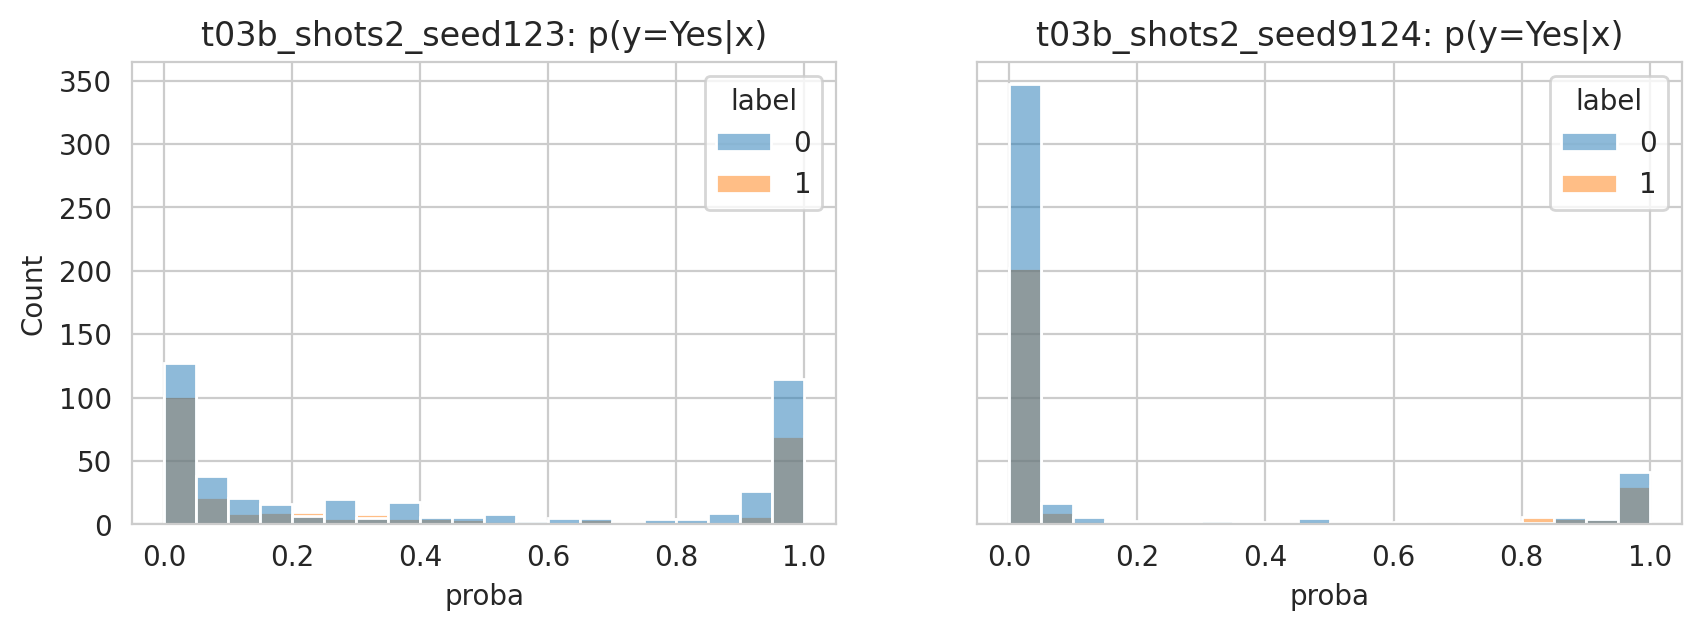

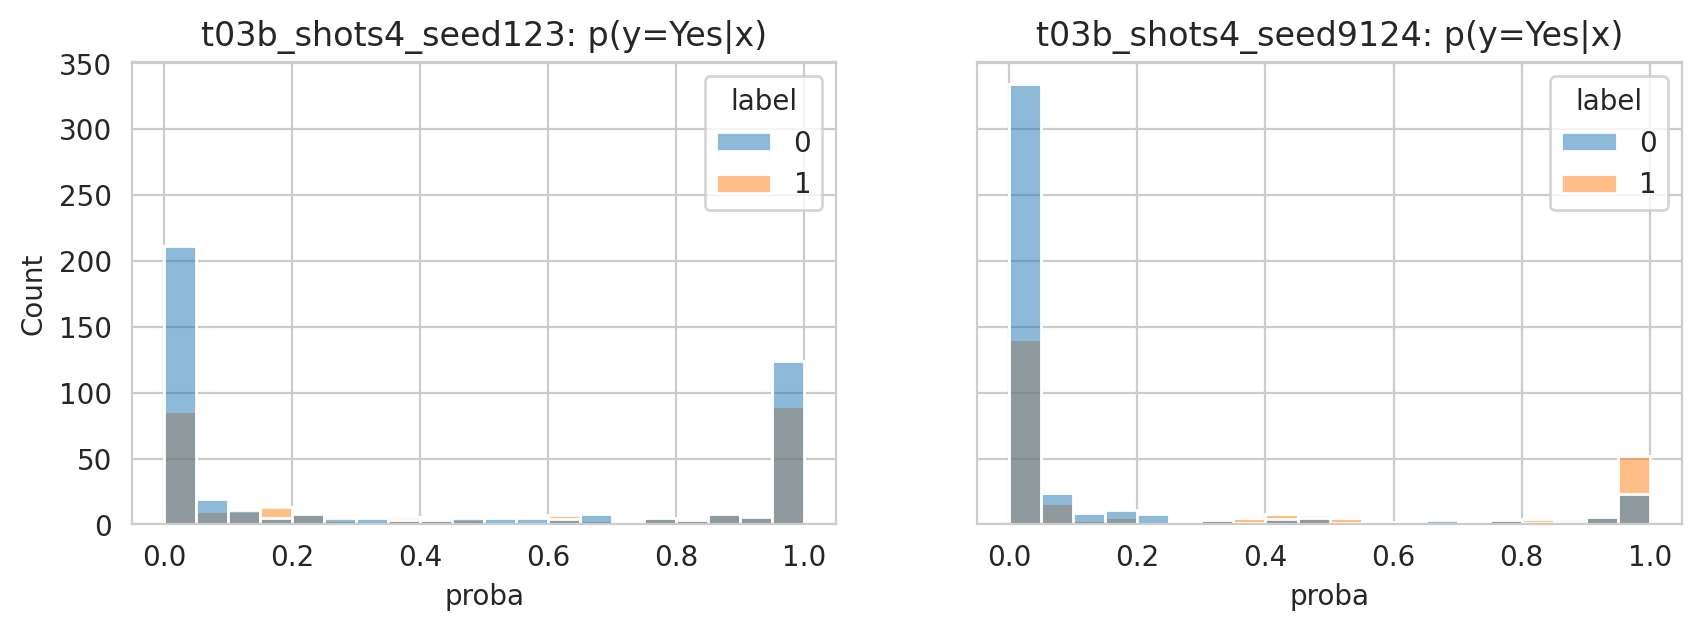

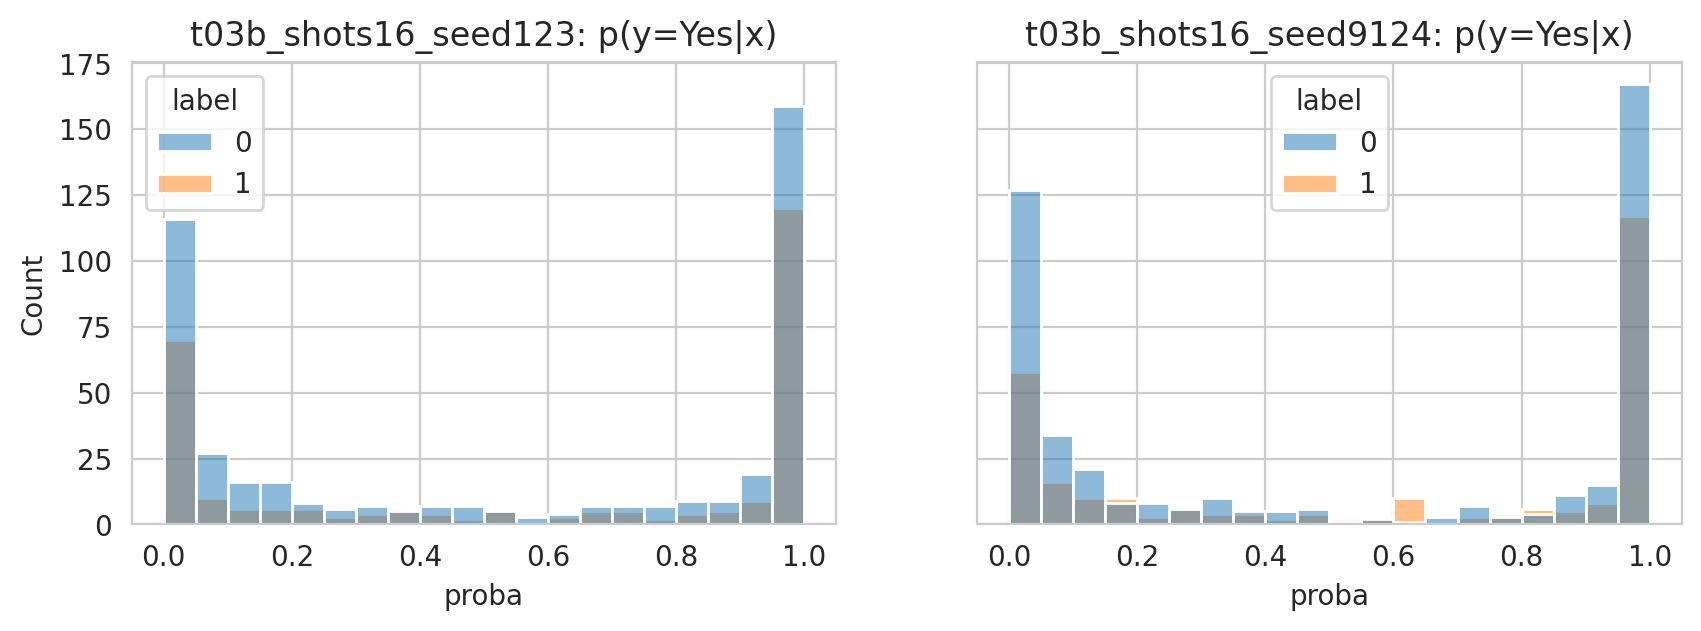

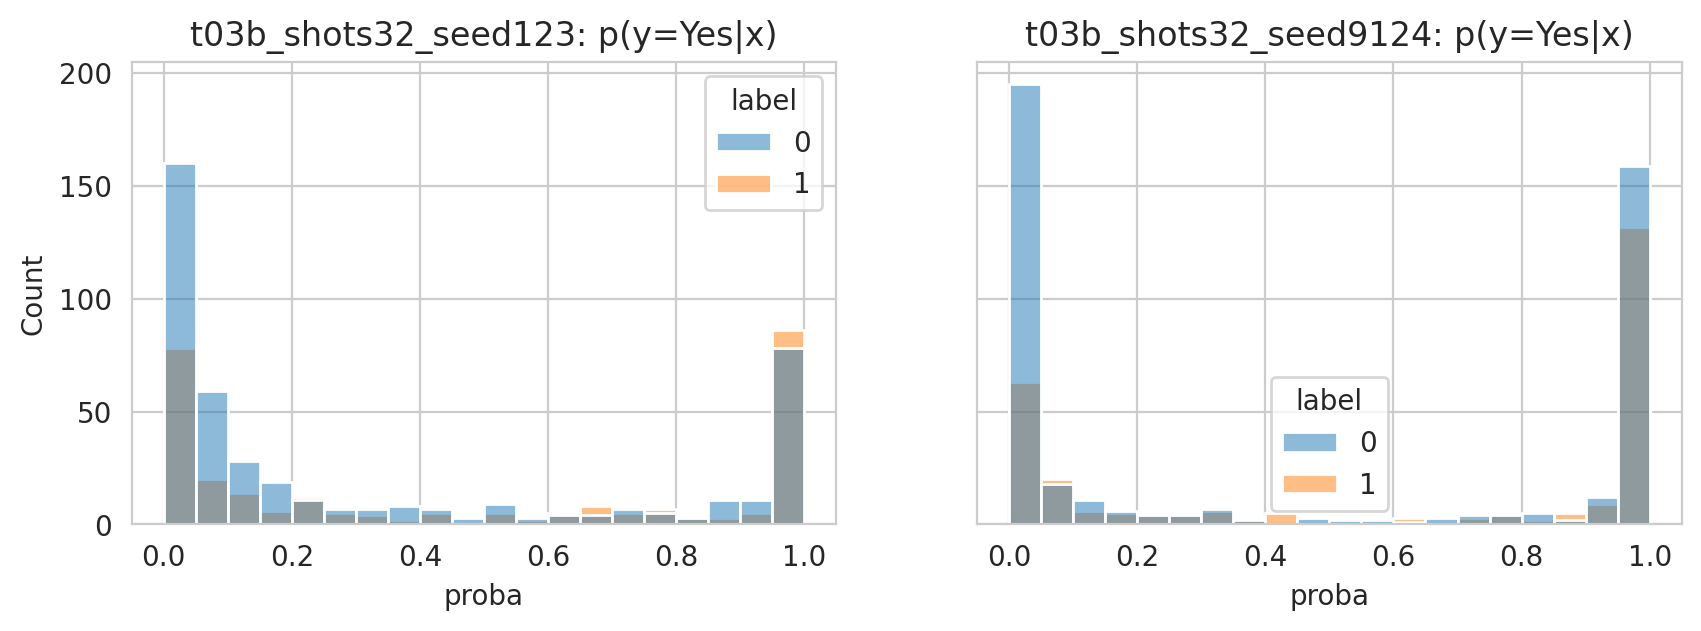

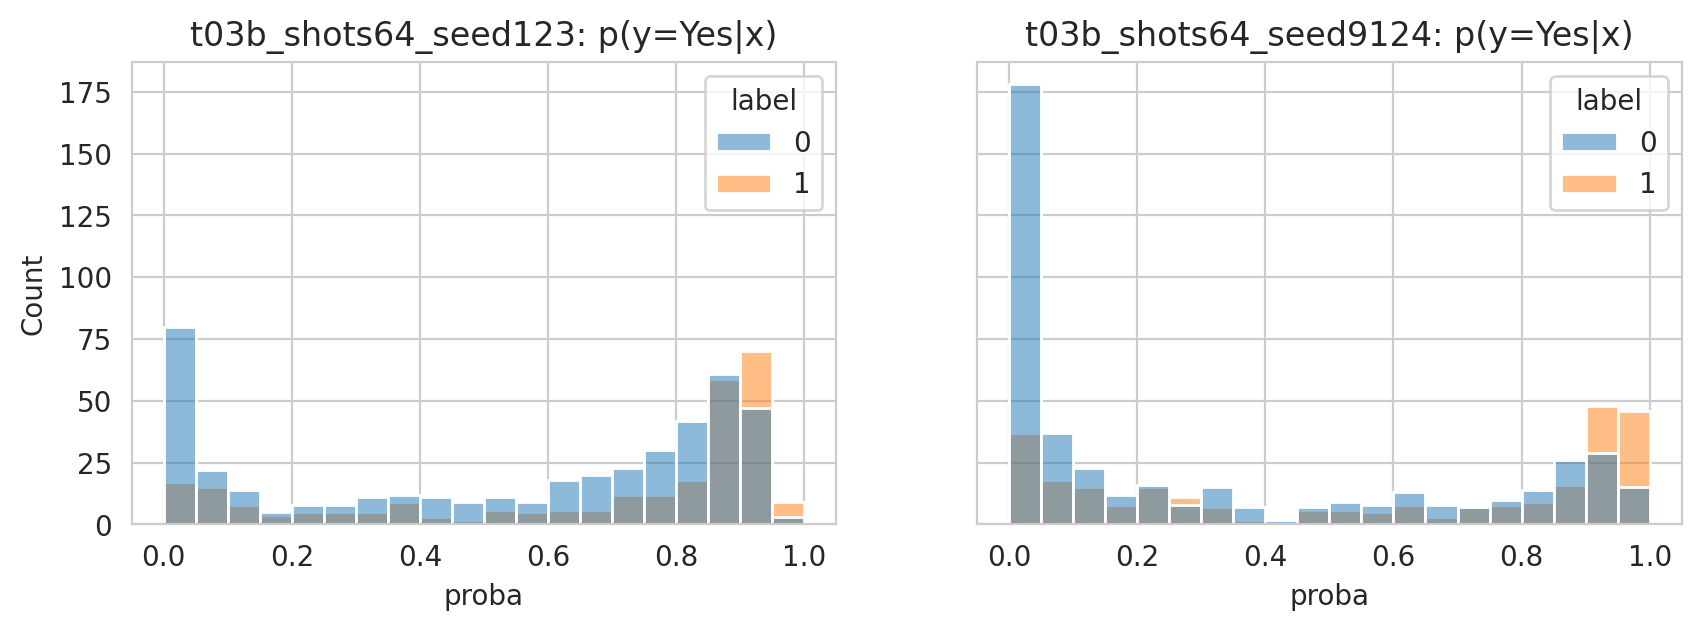

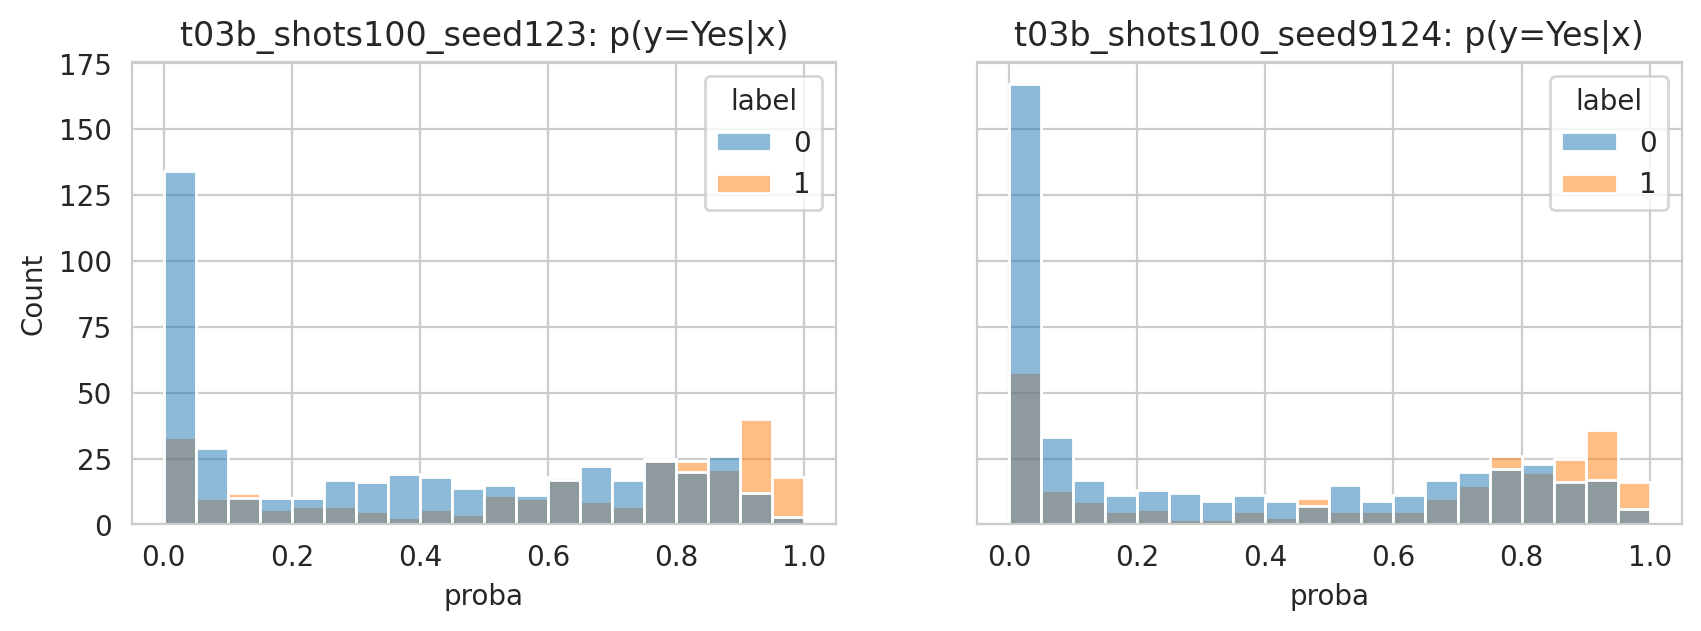

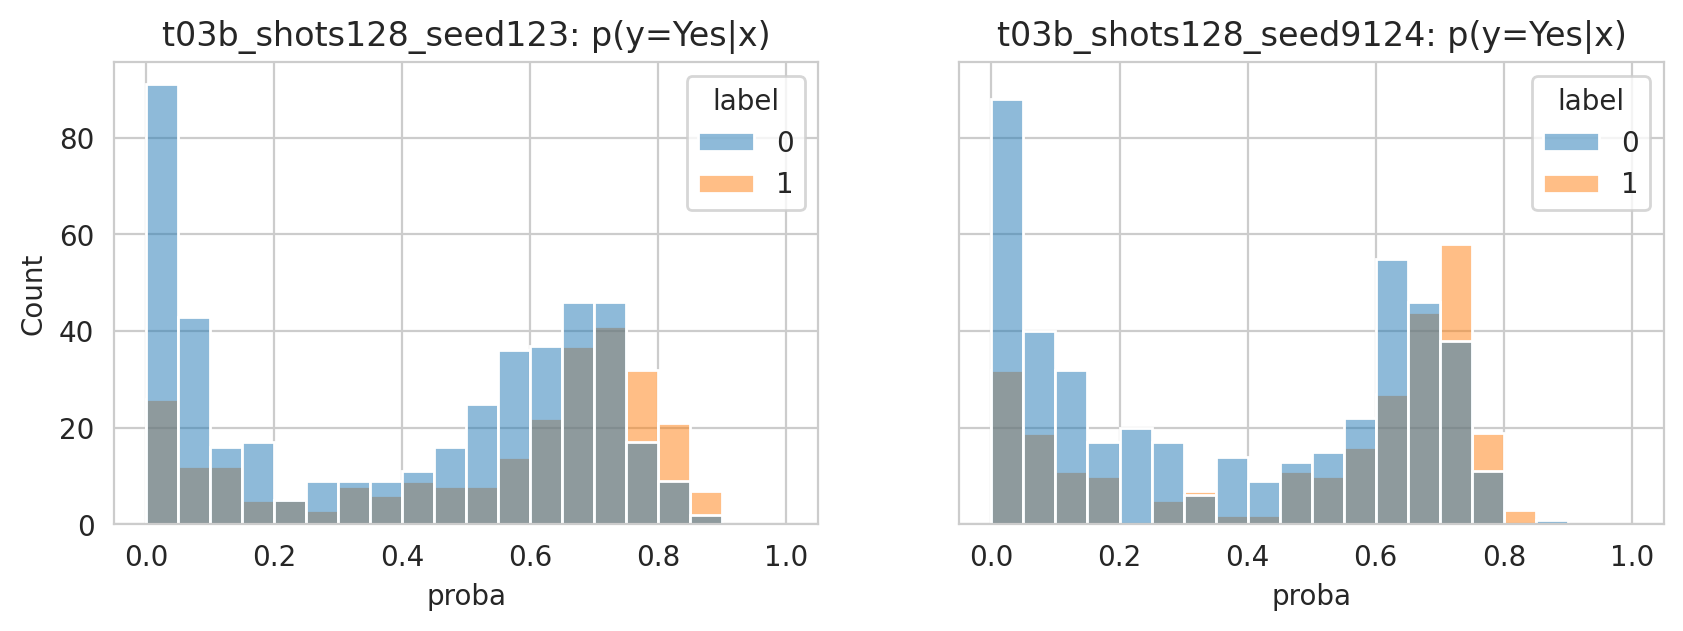

In [39]:
dev_exp_names = sorted(dev_shots.keys(), key=lambda s: int(s.split("_")[1][5:]))
hist_kwargs = {"bins": 20, "binrange": (0, 1), "hue": "label"}

exp_names1, exp_names2 = dev_exp_names[::14], dev_exp_names[4::14]

for exp_name1, exp_name2 in zip(exp_names1, exp_names2):
    
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 3), dpi=200)
    
    # Plot human eval scores
    exp_values = dev_shots[exp_name1]
    scores = np.exp(exp_values["log.scores_class_1"])
    exp_values["proba"] = scores
    sns.histplot(data=exp_values, x="proba", **hist_kwargs, ax=axes[0])
    axes[0].set_title(f"{exp_name1}: p(y=Yes|x)")
    
    # Plot model scores
    
    exp_values = dev_shots[exp_name2]
    scores = np.exp(exp_values["log.scores_class_1"])
    exp_values["proba"] = scores
    sns.histplot(data=exp_values, x="proba", **hist_kwargs, ax=axes[1])
    axes[1].set_title(f"{exp_name2}: p(y=Yes|x)")
    
    plt.show()
    
    print("\n\n\n")

720
720
Document ID: 2


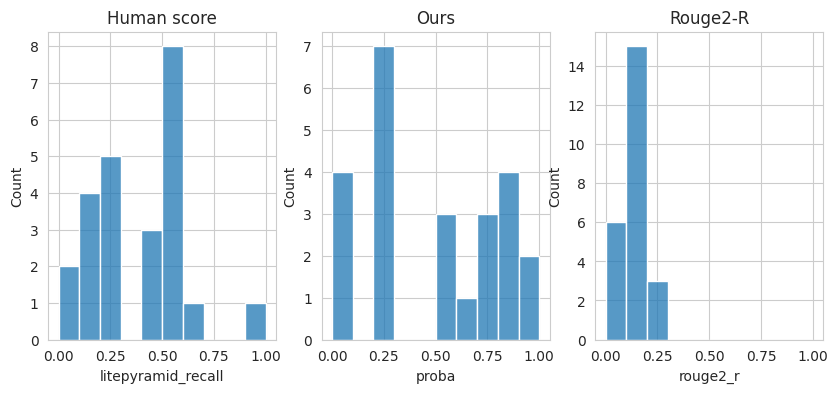

Document ID: 16


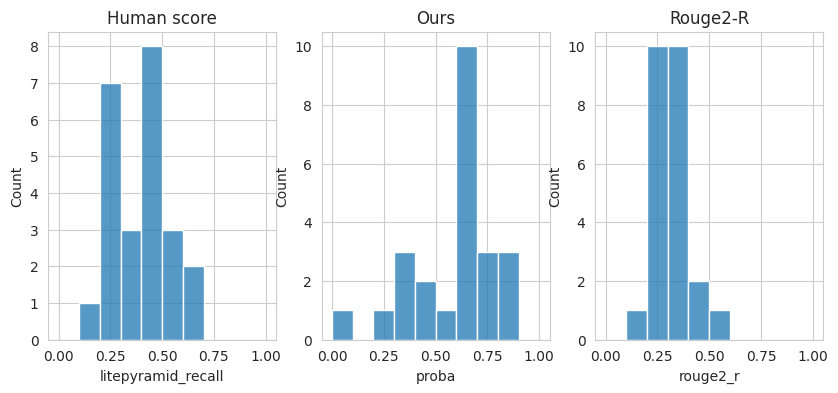

Document ID: 32


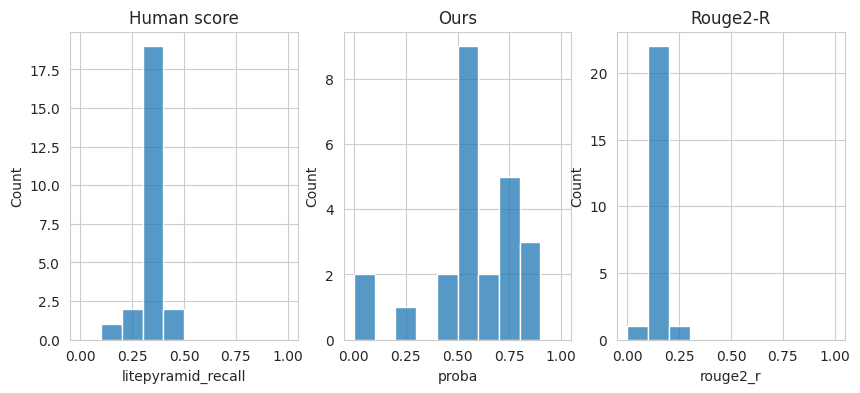

Document ID: 42


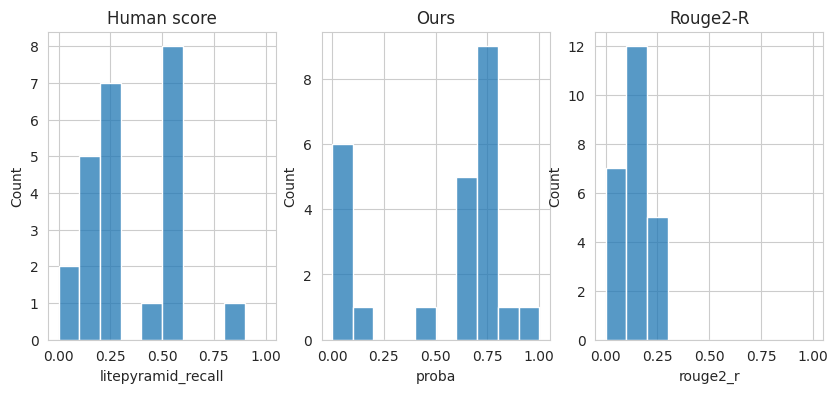

Document ID: 49


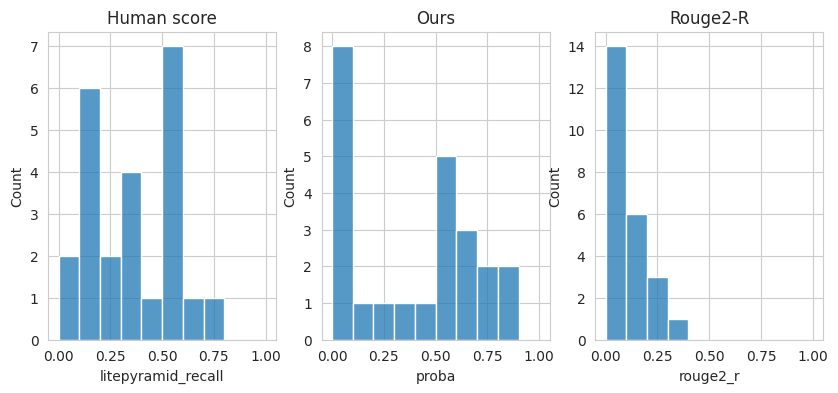

Document ID: 62


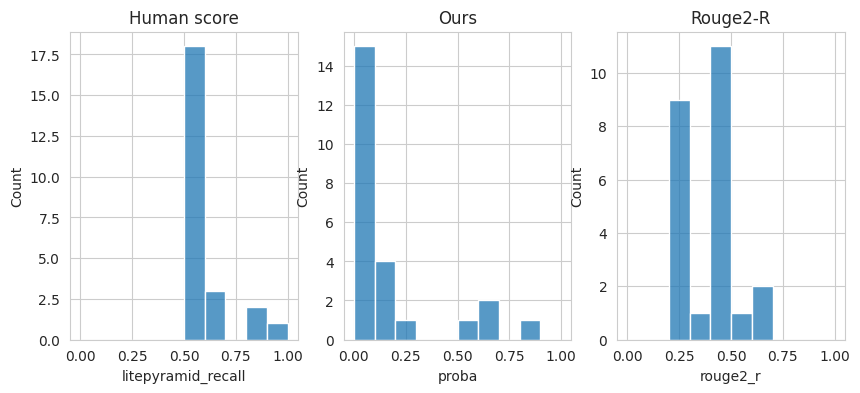

Document ID: 85


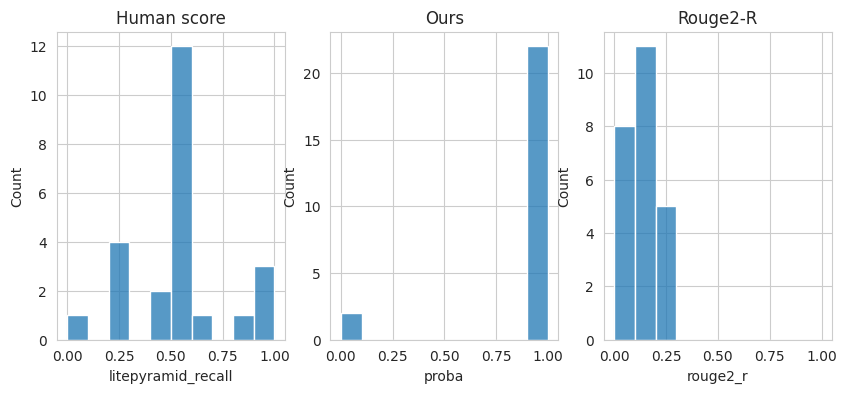

Document ID: 92


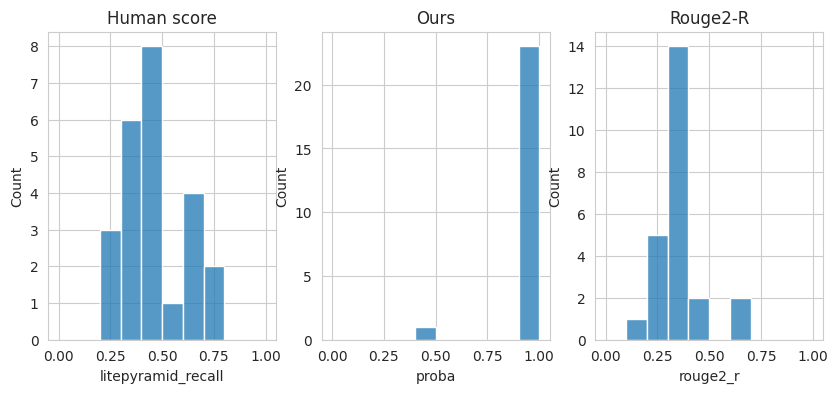

In [68]:
d1 = pd.read_csv("./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed12315_shots100_ia3_pretrained100k/dev_pred.txt")
print(len(d1))
d1 = d1.merge(realsumm, left_on="idx", right_on="index")
print(len(d1))

for bid in sorted(d1.bartscore_doc_id.unique())[::4]:
    data = d1[d1["bartscore_doc_id"] == bid].copy()
    data["proba"] = data["log.scores_class_1"].apply(np.exp)
    print("Document ID:", bid)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    
    ax = axes[0]
    ax.set_title("Human score")
    sns.histplot(ax=ax, data=data, x="litepyramid_recall", binrange=(0, 1), bins=10)
    
    
    ax = axes[1]
    ax.set_title("Ours")
    sns.histplot(ax=ax, data=data, x="proba", binrange=(0, 1), bins=10)
    
    
    ax = axes[2]
    ax.set_title("Rouge2-R")
    sns.histplot(ax=ax, data=data, x="rouge2_r", binrange=(0, 1), bins=10)
    plt.show()

720
720
Document ID: 2


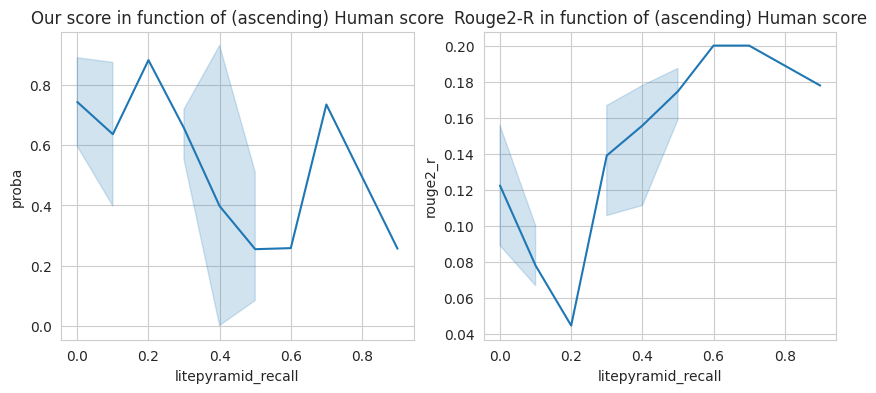

Document ID: 6


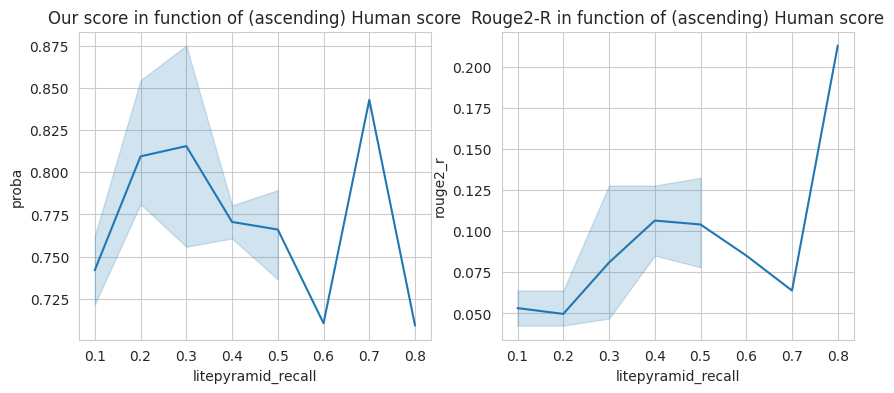

Document ID: 16


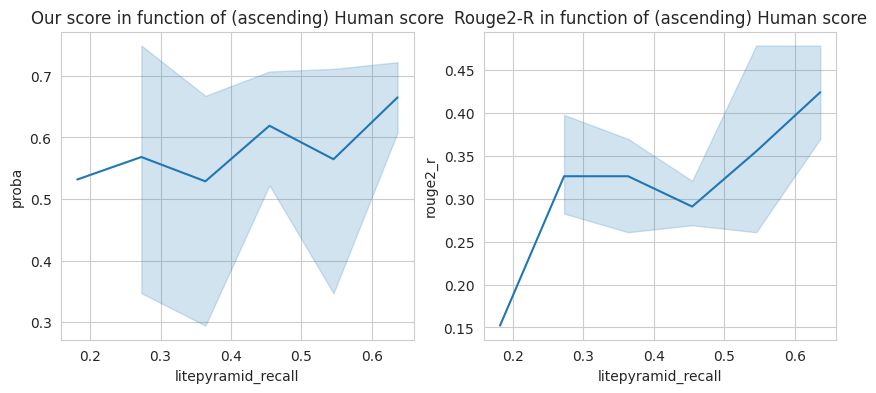

Document ID: 23


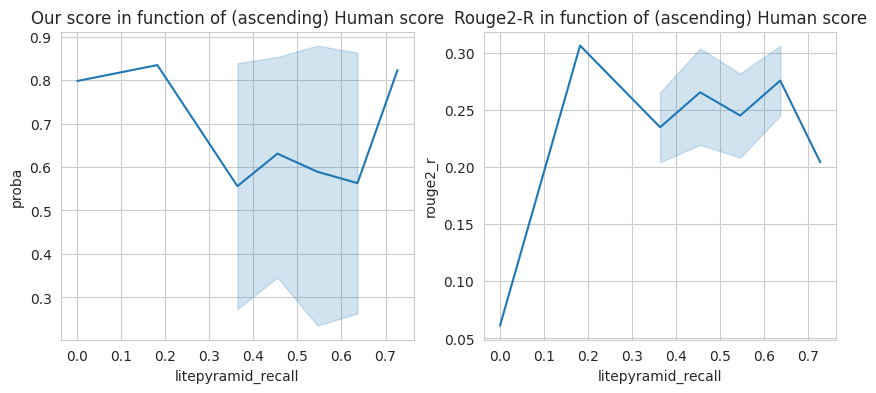

Document ID: 32


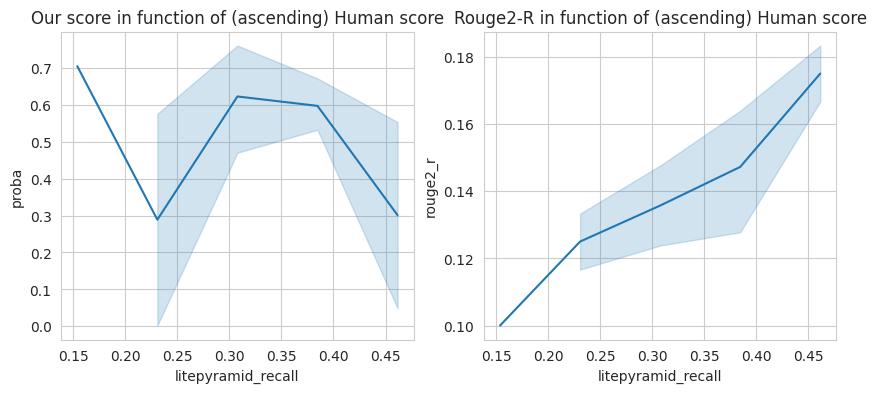

Document ID: 35


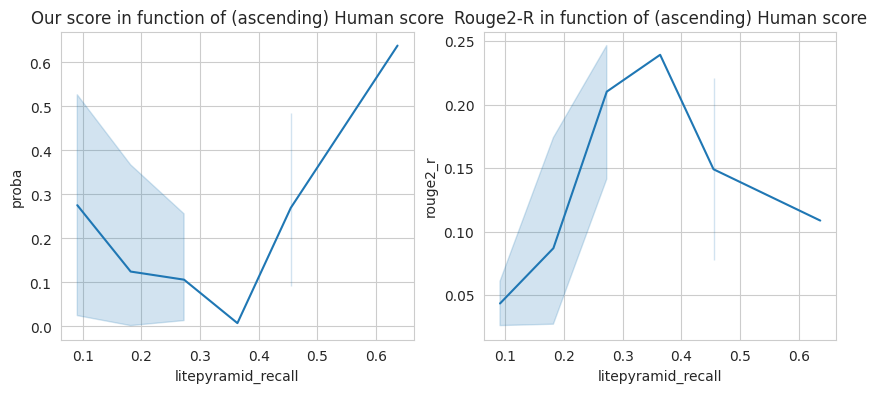

Document ID: 42


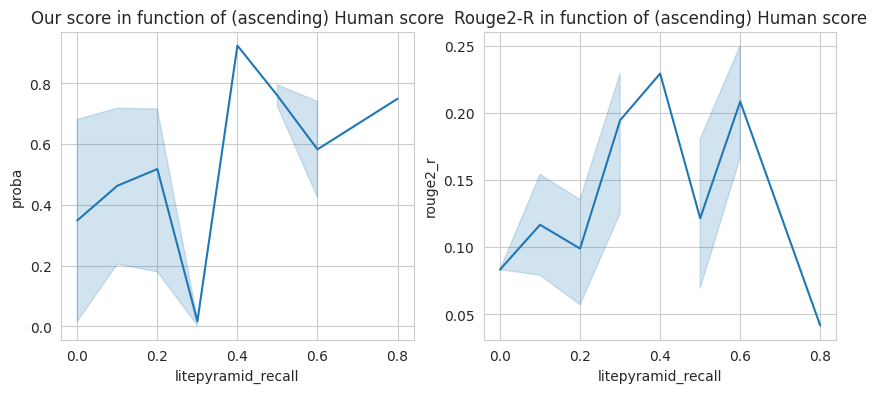

Document ID: 47


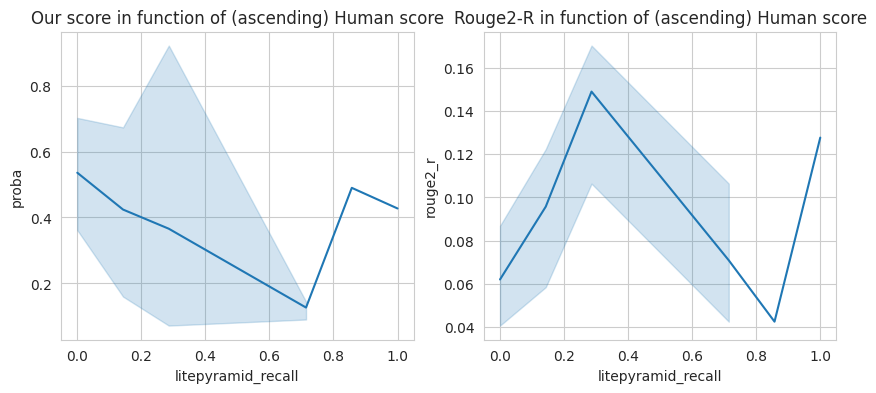

Document ID: 49


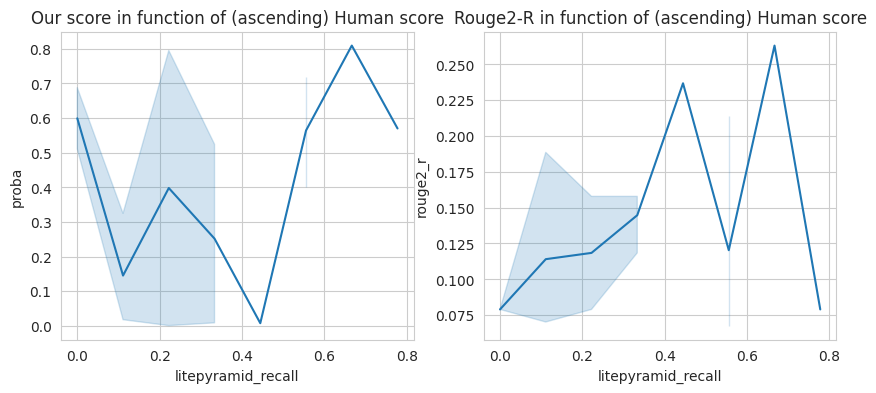

Document ID: 52


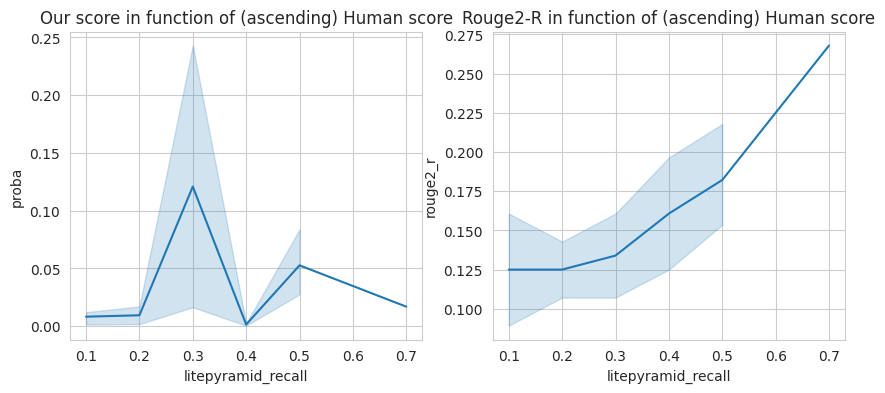

Document ID: 62


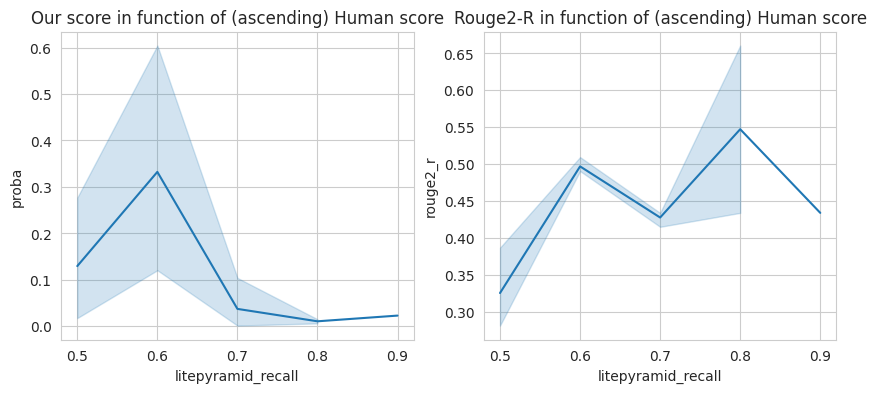

Document ID: 73


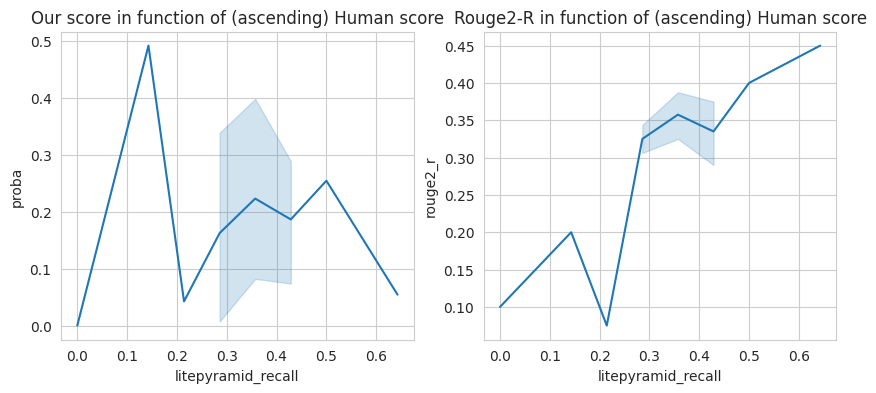

Document ID: 85


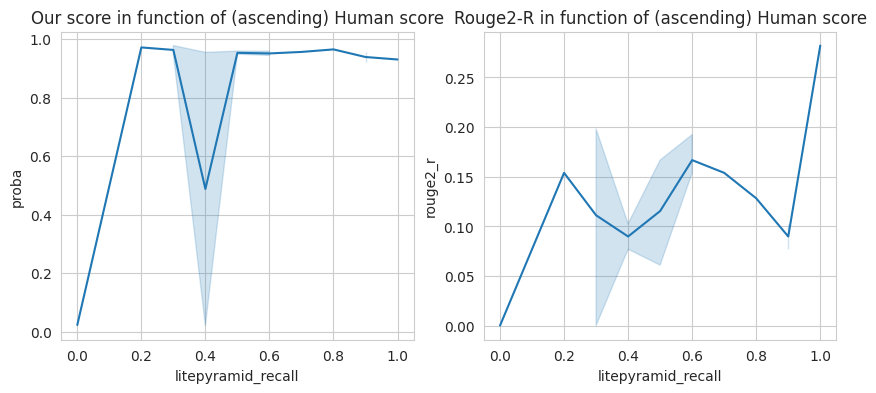

Document ID: 89


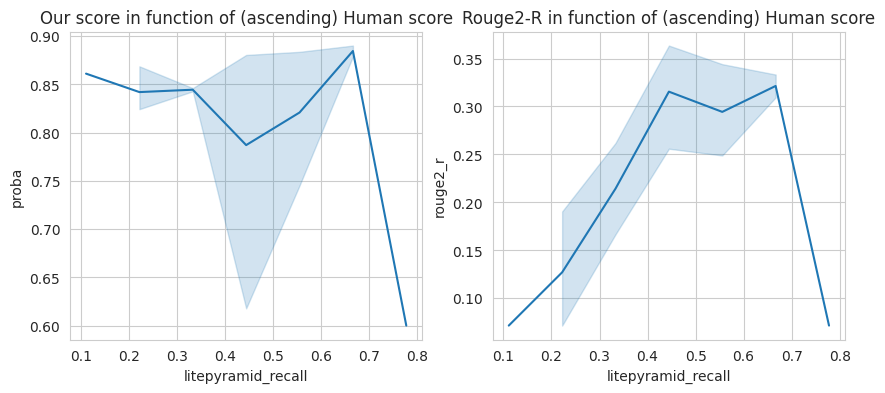

Document ID: 92


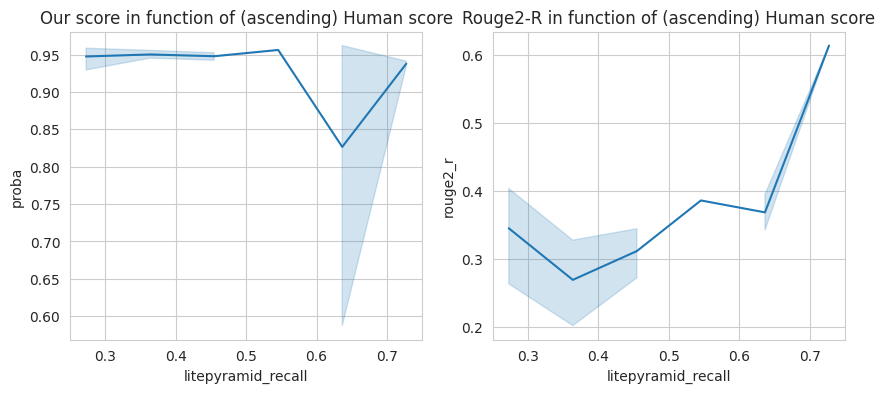

In [71]:
d1 = pd.read_csv("./t-few-master/exp_out_2022_sep_10/realsumm/2class/t03b_realsumm_2class_seed12315_shots100_ia3_pretrained100k/dev_pred.txt")
print(len(d1))
d1 = d1.merge(realsumm, left_on="idx", right_on="index")
print(len(d1))

for bid in sorted(d1.bartscore_doc_id.unique())[::2]:
    data = d1[d1["bartscore_doc_id"] == bid].copy().sort_values("litepyramid_recall")
    data["proba"] = data["log.scores_class_1"].apply(np.exp)
    print("Document ID:", bid)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    ax = axes[0]
    ax.set_title("Our score in function of (ascending) Human score")
    sns.lineplot(ax=ax, data=data, x="litepyramid_recall", y="proba")
    
    
    ax = axes[1]
    ax.set_title("Rouge2-R in function of (ascending) Human score")
    sns.lineplot(ax=ax, data=data, x="litepyramid_recall", y="rouge2_r")
    
    plt.show()

System_name: banditsumm_out.txt


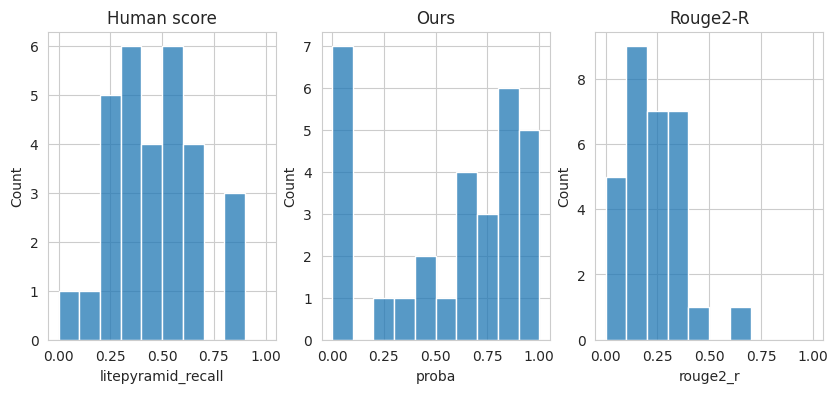

System_name: heter_graph_out.txt


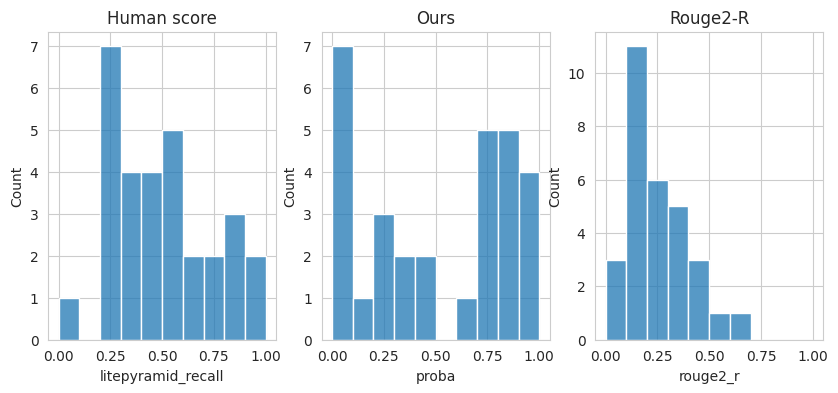

System_name: pnbert_out_bert_lstm_pn_rl.txt


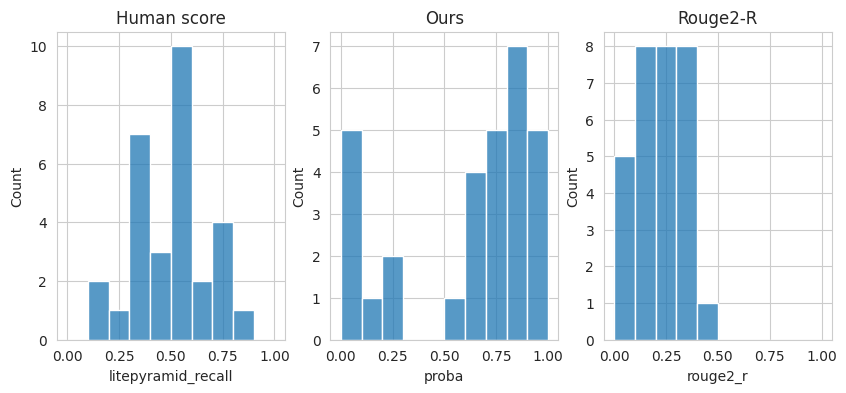

System_name: presumm_out_abs.txt


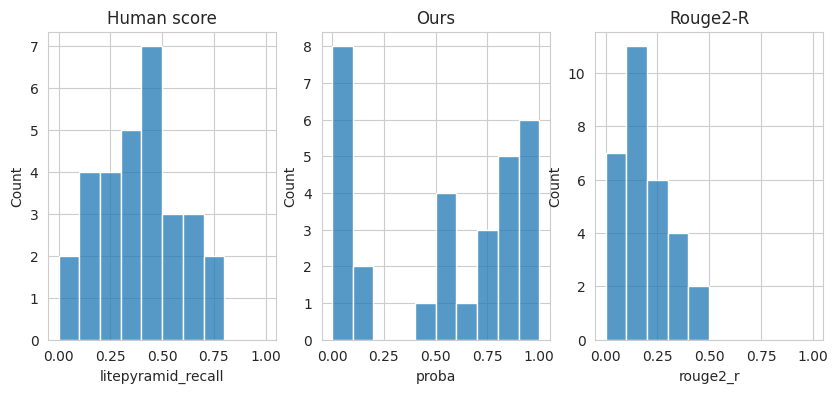

System_name: refresh_out.txt


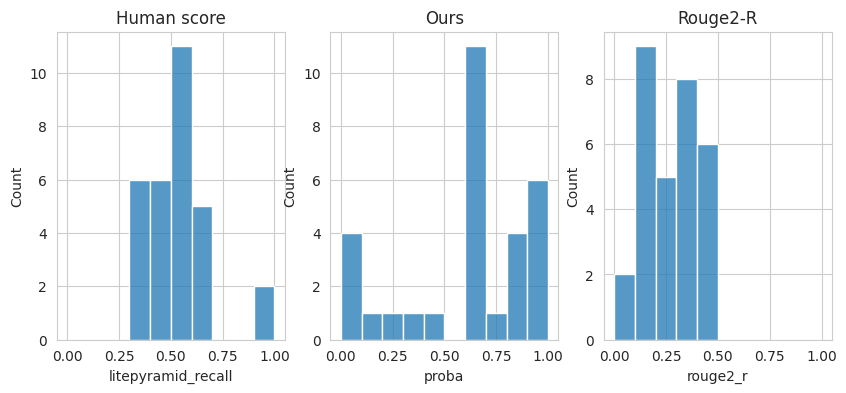

System_name: t5_out_large.txt


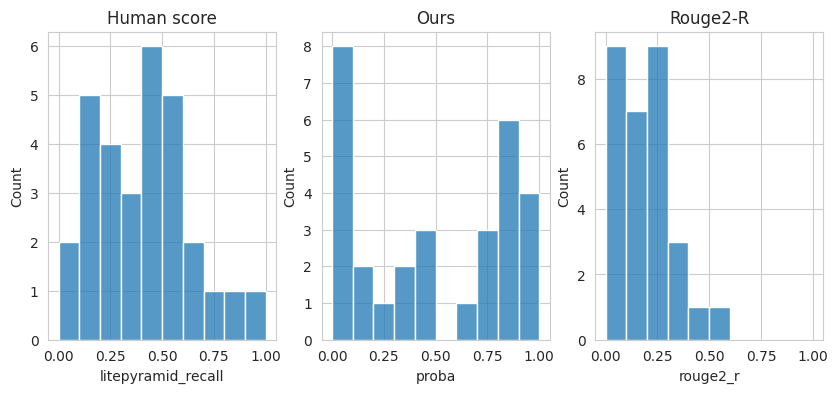

In [67]:
for sys_name in sorted(d1.sys_name.unique())[::4]:
    data = d1[d1["sys_name"] == sys_name].copy()
    data["proba"] = data["log.scores_class_1"].apply(np.exp)
    print("System_name:", sys_name)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    
    ax = axes[0]
    ax.set_title("Human score")
    sns.histplot(ax=ax, data=data, x="litepyramid_recall", binrange=(0, 1), bins=10)
    
    
    ax = axes[1]
    ax.set_title("Ours")
    sns.histplot(ax=ax, data=data, x="proba", binrange=(0, 1), bins=10)
    
    
    ax = axes[2]
    ax.set_title("Rouge2-R")
    sns.histplot(ax=ax, data=data, x="rouge2_r", binrange=(0, 1), bins=10)
    plt.show()

sys_name  litepyramid_recall
0         presumm_out_trans_abs.txt            0.300000
1              two_stage_rl_out.txt            0.100000
2                  unilm_out_v2.txt            0.300000
3                  t5_out_large.txt            0.300000
4           presumm_out_ext_abs.txt            0.200000
..                              ...                 ...
715              banditsumm_out.txt            0.666667
716  pnbert_out_bert_lstm_pn_rl.txt            0.777778
717       pnbert_out_bert_tf_pn.txt            0.666667
718               matchsumm_out.txt            0.222222
719     pnbert_out_bert_lstm_pn.txt            0.888889

[720 rows x 2 columns]

In [81]:
truncated_ex = [16, 20, 64, 88, 101, 112, 120, 124, 127, 129, 136, 140, 160, 168, 175, 177, 181, 183, 184, 187, 188, 189, 190, 191, 208, 244, 246, 264, 280, 281, 282, 284, 312, 328, 390, 400, 472, 496, 503, 504, 511, 512, 519, 520, 544, 568, 591, 592, 594, 595, 596, 598, 600, 614, 615, 616, 617, 618, 620, 621, 622, 623, 626, 638, 640, 641, 642, 643, 644, 645, 646, 647, 664, 688]
len(truncated_ex)

len(realsumm_dev[realsumm_dev["index"].isin(truncated_ex)])


39